In [1]:
# Needed for functions
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import time

# Import Qiskit Classes
from qiskit import *
from qiskit import IBMQ
from qiskit import transpile
from qiskit.providers.aer import AerSimulator, QasmSimulator, noise
from qiskit.providers.aer.extensions import *
from qiskit import quantum_info as qi
from qiskit.test.mock import FakeBogota, FakeSantiago
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc

# Import Visualization Tools
from qiskit.tools.visualization import plot_histogram as plth
from qiskit.visualization import plot_state_city, plot_state_hinton
from qiskit.tools.monitor import job_monitor
from qiskit.tools.jupyter import *


In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')


In [3]:
qcomp_M = provider.get_backend('ibmq_manila')
qcomp_M

<IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>

In [7]:
qcomp_B = provider.get_backend('ibmq_bogota')
qcomp_B

<IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>

In [8]:
qcomp_S = provider.get_backend('ibmq_santiago')
qcomp_S

<IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>

In [9]:
qcomp_sim_B = AerSimulator.from_backend(FakeBogota())
qcomp_sim_S = AerSimulator.from_backend(FakeSantiago())


In [10]:
# Parametros libres globales
p_amp = 0.05
p_phs = 0.05
p_dprz = 0.05
shots = 8192

# Funcion para construir el circuito de codificación de 4 qubits para estados de Bell
def codBell(creg = True):
    """
    Función que construye los pasos para realizar una codificación de 4
    qubits sobre un grado de tipo l para obtener un estado de Bell entre
    sus extremos, usando un circuito construido mediante la teoría de QLNC.
    
    PARAMETROS:
        creg: Variable de tipo Booleano, para añadir o no un registro clásico.
        
    SALIDAS:
        qc: Circuito de la codificación.
    """
    qr = QuantumRegister(4, 'q')
    if creg:
        cr = ClassicalRegister(2, 'c')
        qc = QuantumCircuit(qr, cr)
    else:
        qc = QuantumCircuit(qr)

    qc.h([0, 1, 2, 3])
    qc.cz([0, 2], [1, 3])
    qc.cz(1, 2)
    qc.h([1, 2])
    
    qc.barrier()

    qc.cx([1, 2],[0, 3])

    qc.barrier()

    qc.h(3)

    return qc

# Funcion para construir el circuito de codificación de 4 qubits para estados GHZ
def codGHZ(creg = True):
    """
    Función que construye los pasos para realizar una codificación de 5
    qubits sobre un grado de tipo L para obtener un estado GHZ, usando
    un circuito construido mediante la teoría de QLNC.
    
    PARAMETROS:
        creg: Variable de tipo Booleano, para añadir o no un registro clásico.
        
    SALIDAS:
        qc: Circuito de la codificación.
    """
    qr = QuantumRegister(5, 'q')
    if creg:
        cr = ClassicalRegister(3, 'c')
        qc = QuantumCircuit(qr, cr)
    else:
        qc = QuantumCircuit(qr)

    qc.h([0, 1, 2, 3, 4])
    qc.cz([0, 2], [1, 3])
    qc.cz([1, 3], [2, 4])
    qc.h([1, 3])

    qc.barrier()

    qc.cx([1, 3],[0, 4])

    qc.barrier()

    return qc

# Función para ruido de Amplitud Damping
def amp_noise(p):
    """
    Funcion que sirve para crear un modelo ruidoso basado en Amplitud Damping
    y devolverlo al usuario, las operaciones sobre un solo qubit afectadas son
    rotación en z, raíz de X, rotación en 3 grados y el operador X, mientras
    que las operaciones sobre 2 qubits afectadas son las puertas X y Z controladas.
    
    PARAMETROS:
        p: Probabilidad de aplicar el efecto del ruido sobre el estado.
        
    SALIDAS:
        noisy_model_dprz: Modelo de ruido completo.
    """
    noise_amp_1 = noise.amplitude_damping_error(p)
    noise_amp_2 = noise_amp_1.tensor(noise_amp_1)
    # Modelo Ruidoso de Amplitud Damping
    noisy_model_amp = noise.NoiseModel()
    noisy_model_amp.add_all_qubit_quantum_error(noise_amp_1,
                                                ['rz', 'sx', 'x', 'u3'])
    noisy_model_amp.add_all_qubit_quantum_error(noise_amp_2,
                                                ['cx', 'cz'])
    return noisy_model_amp

# Función para ruido de Depolarizing
def phs_noise(p):
    """
    Crea un modelo ruidoso basado en Phase Damping y devolverlo al usuario,
    las operaciones sobre un solo qubit afectadas son rotación en z, raíz
    de X, rotación en 3 grados y el operador X, mientras que las operaciones
    sobre 2 qubits afectadas son las puertas X y Z controladas.
    
    PARAMETROS:
        p: Probabilidad de aplicar el efecto del ruido sobre el estado.
        
    SALIDAS:
        noisy_model_dprz: Modelo de ruido completo.
    """
    noise_phs_1 = noise.phase_damping_error(p)
    noise_phs_2 = noise_phs_1.tensor(noise_phs_1)
    # Modelo Ruidoso de Phase Damping
    noisy_model_phs = noise.NoiseModel()
    noisy_model_phs.add_all_qubit_quantum_error(noise_phs_1,
                                                ['rz', 'sx', 'x', 'u3'])
    noisy_model_phs.add_all_qubit_quantum_error(noise_phs_2,
                                                ['cx', 'cz'])
    return noisy_model_phs

# Función para ruido de Depolarizing
def dprz_noise(p):
    """
    Crea un modelo ruidoso basado en Depolarizing y devolverlo al usuario,
    las operaciones sobre un solo qubit afectadas son rotación en z, raíz
    de X, rotación en 3 grados y el operador X, mientras que las operaciones
    sobre 2 qubits afectadas son las puertas X y Z controladas.
    
    PARAMETROS:
        p: Probabilidad de aplicar el efecto del ruido sobre el estado.
        
    SALIDAS:
        noisy_model_dprz: Modelo de ruido completo.
    """
    noise_dprz_1 = noise.depolarizing_error(p, 1)
    noise_dprz_2 = noise.depolarizing_error(p, 2)
    # Modelo Ruidoso de Depolarizing
    noisy_model_dprz = noise.NoiseModel()
    noisy_model_dprz.add_all_qubit_quantum_error(noise_dprz_1,
                                                 ['rz', 'sx', 'x', 'u3'])
    noisy_model_dprz.add_all_qubit_quantum_error(noise_dprz_2,
                                                 ['cx', 'cz'])
    return noisy_model_dprz

#Función para calcular la fidelidad
def fid(qc, qc_noise, noise_model, shots):
    """
    Calcular la fidelidad cuántica entre 2 circuitos, uno ideal y otro con
    ruido. Como el simulador de estados incluido en QISKit realiza n cantidad
    de corridas, es necesario calcular la fidelidad individual de cada una y
    después promediar el resultado para luego devolverlo al usuario.
    
    PARAMETROS:
        qc: Circuito sin ruido.
        qc_noise: Circuito con ruido.
        noise_model: Modelo del ruido.
        shots: Número de simulaciones.
    SALIDAS:
        f/j: Promedio de las fidelidades calculadas en cada corrida.
    """
    
    f = 0
    j = 0
    
    sv_qc = qc.copy()
    sv_qc.snapshot_statevector('final')
    sv = execute(sv_qc, QasmSimulator()).result().data(0)['snapshots']['statevector']['final'][0]

    #Circuitos simulados con el ruido clasico
    sv_qc_noise = qc_noise.copy()
    sv_qc_noise.snapshot_statevector('final')
    sv_noise = execute(sv_qc_noise, QasmSimulator(), shots=shots, noise_model=noise_model,
                       basis_gates=noise_model.basis_gates
                      ).result().data(0)['snapshots']['statevector']['final']
    for i in range (0, len(sv_noise)):
        if np.round(abs(sum([n ** 2 for n in sv_noise[i]])),4)==1.0000:
            j += 1
            f += qi.state_fidelity(sv, sv_noise[i])
            
    
    return f/j

#Función para calcular la matriz densidad usando tomografía
def tomo(qc, backend, qubits=[], cal_id = [], tomo_id = [], trans=True):
    """
    Calcular la matriz densidad de un circuito cuántico a partir de
    los resultados experimentales en forma de probabilidades, usando
    el método de tomografía cuántica con la subrutina de mitigación
    de errores en la medida mediante la calibración de un filtro
    construido a partir de los resultados en el error por cada posible
    combinación del registro cuántico.
    
    PARAMETROS:
        qc: Circuito cuántico.
        backend: Backend del dispositivo que se esté utilizando.
        qubits: Lista con los qubits relacionados a la medida
        cal_id: Lista con los marcadores en el backend de los circuitos
            para calibración.
        tomo_id: Lista con los marcadores en el backend de los circuitos
            para calcular la tomografía.
        transpile: Variable de tipo booleana para determinar si hay o no
            que transpilar el circuito. Especialmente útil para simular
            ruidos.
        noise: Lista con los modelos de ruido a aplicar durante la tomo-
            grafía.
    SALIDAS:
        P: 
            Matriz densidad obtenida sin filtrar el ruido.
        job_tomo.result().time_taken/60: 
            Tiempo de ejecución de los circuitos para la tomografía
            dentro del backend.
        P_mit: 
            Matriz densidad obtenida sin filtrar el ruido.
        (job_cal.result().time_taken+job_tomo.result().time_taken)/60: 
            Tiempo de ejecución de los circuitos para  la tomografía
            y calibración del filtro dentro del backend.
    """
        
    # Generate Circuits and Fitter for Calibration tomography.
    if trans:
        tqc_tomo = transpile(qc, backend)
    else:
        tqc_tomo = qc.copy()

    if len(qubits)==0:
        qst_tqc = state_tomography_circuits(tqc_tomo,
                                            tqc_tomo.qubits)
        meas_cal, state_labels = mc.complete_meas_cal(tqc_tomo.qubits)

    else:
        qst_tqc = state_tomography_circuits(tqc_tomo,
                                            qubits)
        meas_cal, state_labels = mc.complete_meas_cal(qubits)

    
    # Execute Job callibrated and not
    if len(cal_id)==0:
        if len(meas_cal)<100:
            job_cal = qiskit.execute(meas_cal, backend=backend, shots=shots)
        else:
            i=100
            job_cal = qiskit.execute(meas_cal[i-100:i], backend=backend, shots=shots)
            while True:
                i+=100
                if(i > len(meas_cal)):
                    print(i)
                    job = qiskit.execute(meas_cal[i-100:len(qst_tqc)],
                                         backend=backend,
                                         shots=shots).result()
                    
                    job_cal.result().results += job.results
                    job_cal.result().time_taken += job.time_taken
                    
                    break
                job = qiskit.execute(meas_cal[i-100:i],
                                     backend=backend,
                                     shots=shots).result()
                
                job_cal.result().results += job.results
                job_cal.result().time_taken += job.time_taken
                    
    else:
        job_cal = backend.retrieve_job(cal_id.pop(0))
        while len(cal_id)!=0:
            job = backend.retrieve_job(cal_id.pop(0)).result()
            
            job_cal.result().results += job.results
            job_cal.result().results += job.time_taken
            
            
    if len(tomo_id)==0:
        if len(qst_tqc)<100:
            job_tomo = qiskit.execute(qst_tqc, backend=backend, shots=shots)
        else:
            i=100
            job_tomo = qiskit.execute(qst_tqc[i-100:i], backend=backend, shots=shots)
            while True:
                i+=100
                if(i > len(qst_tqc)):
                    job = qiskit.execute(qst_tqc[i-100:len(qst_tqc)],
                                                   backend=backend,
                                                   shots=shots).result()
                    
                    job_tomo.result().results += job.results
                    job_tomo.result().time_taken += job.time_taken
                    
                    break
                job = qiskit.execute(qst_tqc[i-100:i],
                                               backend=backend,
                                               shots=shots).result()
                
                job_tomo.result().results += job.results
                job_tomo.result().time_taken += job.time_taken
                    
    else:
        job_tomo = backend.retrieve_job(tomo_id.pop(0))
        while len(tomo_id)!=0:
            job = backend.retrieve_job(tomo_id.pop(0)).result()

            job_tomo.result().results += job.results
            job_tomo.result().time_taken += job.time_taken
            
    meas_fitter = mc.CompleteMeasFitter(job_cal.result(), state_labels)
    tomo_tqc = StateTomographyFitter(job_tomo.result(), qst_tqc)

    # no correction
    P = tomo_tqc.fit(method='lstsq')

    # corrected data
    corr_tomo_tqc_res = meas_fitter.filter.apply(job_tomo.result(), method='least_squares')
    tomo_tqc_mit = StateTomographyFitter(corr_tomo_tqc_res, qst_tqc)
    P_mit = tomo_tqc_mit.fit(method='lstsq')
    
    return [P, job_tomo.result().time_taken/60, P_mit, (job_cal.result().time_taken+job_tomo.result().time_taken)/60]


Profundidad del Circuito, estado de Bell:  6
Profundidad del Circuito, estado GHZ:  5


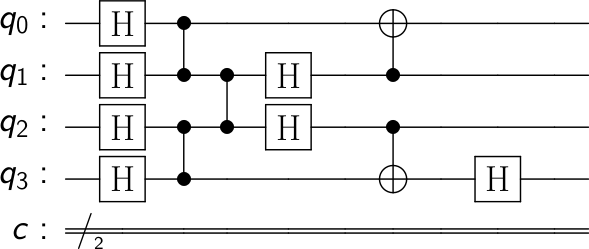

None

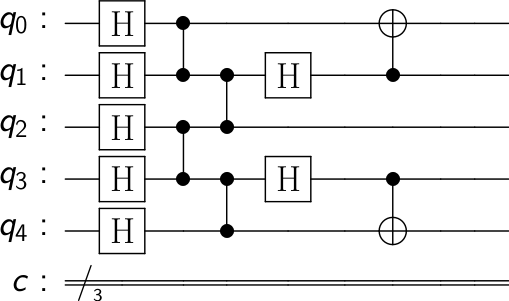

None

In [11]:
qc_Bell = codBell()
lis_Bell=[1, 2]
mes_Bell=[0, 3]
creg_Bell=[0, 1]

qc_GHZ = codGHZ()
lis_GHZ=[1, 3]
mes_GHZ=[0, 2, 4]
creg_GHZ=[0, 1, 3]

display(qc_Bell.draw(output = 'latex', plot_barriers=False),
        print("Profundidad del Circuito, estado de Bell: ", qc_Bell.depth()),
        qc_GHZ.draw(output = 'latex', plot_barriers=False),
        print("Profundidad del Circuito, estado GHZ: ", qc_GHZ.depth())
       )


In [ ]:
Statevector&([ 3,53553391e-01+0,j,  8,34944624e-18+0,j,  3,53553391e-01+0,j,\\
             & 8,34944624e-18+0,j,  3,24757183e-34+0,j, -4,76210391e-18+0,j,\\
             & 3,24757183e-34+0,j, -4,76210391e-18+0,j,  3,53553391e-01+0,j,\\
             & 8,34944624e-18+0,j,  3,53553391e-01+0,j,  8,34944624e-18+0,j,\\
             & 3,24757183e-34+0,j, -4,76210391e-18+0,j,  3,24757183e-34+0,j,\\
             &-4,76210391e-18+0,j, -4,76210391e-18+0,j,  3,24757183e-34+0,j,\\
             &-4,76210391e-18+0,j,  3,24757183e-34+0,j,  8,34944624e-18+0,j,\\
             & 3,53553391e-01+0,j,  8,34944624e-18+0,j,  3,53553391e-01+0,j,\\
             &-4,76210391e-18+0,j,  3,24757183e-34+0,j, -4,76210391e-18+0,j,\\
             & 3,24757183e-34+0,j,  8,34944624e-18+0,j,  3,53553391e-01+0,j,\\
             & 8,34944624e-18+0,j,  3,53553391e-01+0,j],\\
            dims=(2, 2, 2, 2, 2))

Statevector([ 3.53553391e-01+0.j,  1.48640518e-17+0.j,  3.53553391e-01+0.j,
              1.48640518e-17+0.j,  3.53553391e-01+0.j,  1.48640518e-17+0.j,
              3.53553391e-01+0.j,  1.48640518e-17+0.j, -4.76210391e-18+0.j,
              3.53553391e-01+0.j, -4.76210391e-18+0.j,  3.53553391e-01+0.j,
             -4.76210391e-18+0.j,  3.53553391e-01+0.j, -4.76210391e-18+0.j,
              3.53553391e-01+0.j],
            dims=(2, 2, 2, 2))
Statevector([ 3.53553391e-01+0.j,  8.34944624e-18+0.j,  3.53553391e-01+0.j,
              8.34944624e-18+0.j,  3.24757183e-34+0.j, -4.76210391e-18+0.j,
              3.24757183e-34+0.j, -4.76210391e-18+0.j,  3.53553391e-01+0.j,
              8.34944624e-18+0.j,  3.53553391e-01+0.j,  8.34944624e-18+0.j,
              3.24757183e-34+0.j, -4.76210391e-18+0.j,  3.24757183e-34+0.j,
             -4.76210391e-18+0.j, -4.76210391e-18+0.j,  3.24757183e-34+0.j,
             -4.76210391e-18+0.j,  3.24757183e-34+0.j,  8.34944624e-18+0.j,
              3.535533

None

C:\ProgramData\Anaconda3\envs\MyEnv\lib\site-packages\qiskit\visualization\state_visualization.py:705: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


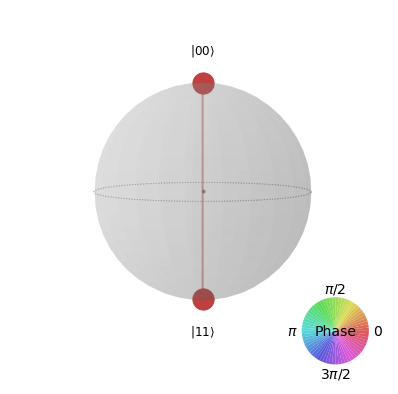

None

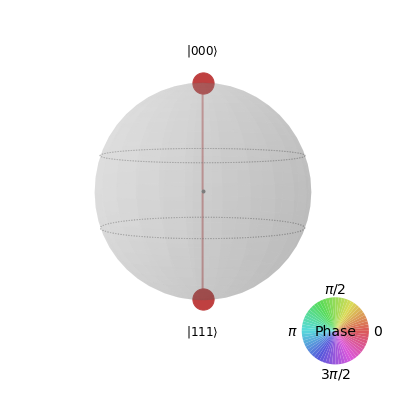

In [12]:
svs = BasicAer.get_backend('statevector_simulator')

qc_Bell_svs = execute(qc_Bell, svs).result()
qc_Bell_P  = qi.DensityMatrix(qc_Bell_svs.get_statevector(qc_Bell))
qc_Bell_sv = qi.Statevector.from_instruction(qc_Bell)

qc_GHZ_svs = execute(qc_GHZ, svs).result()
qc_GHZ_P  = qi.DensityMatrix(qc_GHZ_svs.get_statevector(qc_GHZ))
qc_GHZ_sv = qi.Statevector.from_instruction(qc_GHZ)

display(print(qc_Bell_sv),
        #qc_P.draw(output='qsphere'),
        qi.partial_trace(qc_Bell_P, lis_Bell).draw(output='qsphere'),
        #plot_state_city(qc_P),
        #plot_state_hinton(qc_P),
        print(qc_GHZ_sv),
        #qc_P.draw(output='qsphere'),
        qi.partial_trace(qc_GHZ_P, lis_GHZ).draw(output='qsphere'),
        #plot_state_city(qc_P),
        #plot_state_hinton(qc_P)
       )



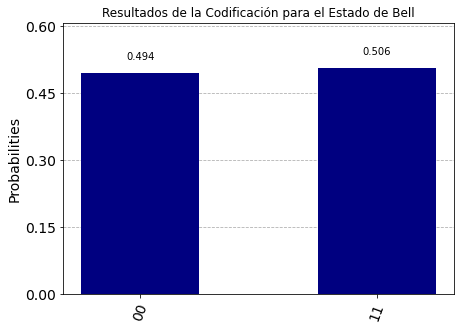

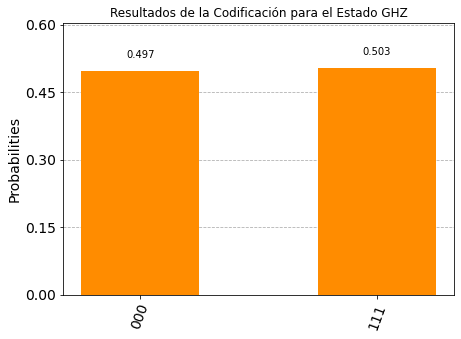

In [25]:
qc_Bell_meas = qc_Bell.copy()
qc_Bell_meas.measure(mes_Bell, [i for i in range(qc_Bell.cregs[0].size)])
qc_GHZ_meas = qc_GHZ.copy()
qc_GHZ_meas.measure(mes_GHZ, [i for i in range(qc_GHZ.cregs[0].size)])

sim = Aer.get_backend('qasm_simulator')

counts_Bell = execute(qc_Bell_meas, backend = sim, shots = shots).result().get_counts()
counts_GHZ = execute(qc_GHZ_meas, backend = sim, shots = shots).result().get_counts()

display(plth(counts_Bell,
             title='Resultados de la Codificación para el Estado de Bell',
             color=[
                 'navy'
             ],
             figsize=(7, 5)
            ),
        plth(counts_GHZ,
             title='Resultados de la Codificación para el Estado GHZ',
             color=[
                 'darkorange'
             ],
             figsize=(7, 5)
            )
       )


In [14]:
print('Cuentas de la codificación para el estado de Bell: \n',counts_Bell)
for i in counts_Bell:
    print(i, ': ',counts_Bell[i], '/',round(counts_Bell[i]/shots, 5))
print('\nCuentas de la codificación para el estado GHZ: \n',counts_GHZ)
for i in counts_GHZ:
    print(i, ': ',counts_GHZ[i], '/',round(counts_GHZ[i]/shots, 5))


Cuentas de la codificación para el estado de Bell: 
 {'11': 4132, '00': 4060}
11 :  4132 / 0.50439
00 :  4060 / 0.49561

Cuentas de la codificación para el estado GHZ: 
 {'111': 4038, '000': 4154}
111 :  4038 / 0.49292
000 :  4154 / 0.50708


In [15]:
# Bell State
# Transpile the circuit for the sistems basis gates
tqc_Bell_sim_b = transpile(qc_Bell, qcomp_sim_B)
tqc_Bell_sim_b_sv = qi.Statevector.from_instruction(tqc_Bell_sim_b)
tqc_Bell_sim_b_meas = tqc_Bell_sim_b.copy()
tqc_Bell_sim_b_meas.measure(mes_Bell, [i for i in range(tqc_Bell_sim_b_meas.cregs[0].size)])

tqc_Bell_sim_s = transpile(qc_Bell, qcomp_sim_S)
tqc_Bell_sim_s_sv = qi.Statevector.from_instruction(tqc_Bell_sim_s)
tqc_Bell_sim_s_meas = tqc_Bell_sim_s.copy()
tqc_Bell_sim_s_meas.measure(mes_Bell, [i for i in range(tqc_Bell_sim_s_meas.cregs[0].size)])

# Transpile the circuit for the sistems basis gates using the real object
tqc_Bell_b = transpile(qc_Bell, qcomp_B)
tqc_Bell_b_sv = qi.Statevector.from_instruction(tqc_Bell_b)
tqc_Bell_b_meas = tqc_Bell_b.copy()
tqc_Bell_b_meas.measure(mes_Bell, [i for i in range(tqc_Bell_b_meas.cregs[0].size)])

tqc_Bell_s = transpile(qc_Bell, qcomp_S)
tqc_Bell_s_sv = qi.Statevector.from_instruction(tqc_Bell_s)
tqc_Bell_s_meas = tqc_Bell_s.copy()
tqc_Bell_s_meas.measure(mes_Bell, [i for i in range(tqc_Bell_s_meas.cregs[0].size)])

tqc_Bell_m = transpile(qc_Bell, qcomp_M)
tqc_Bell_m_sv = qi.Statevector.from_instruction(tqc_Bell_m)
tqc_Bell_m_meas = tqc_Bell_m.copy()
tqc_Bell_m_meas.measure(mes_Bell, [i for i in range(tqc_Bell_m_meas.cregs[0].size)])

###########################################################################################
# GHZ State
# Transpile the circuit for the sistems basis gates
tqc_GHZ_sim_b = transpile(qc_GHZ, qcomp_sim_B)
tqc_GHZ_sim_b_sv = qi.Statevector.from_instruction(tqc_GHZ_sim_b)
tqc_GHZ_sim_b_meas = tqc_GHZ_sim_b.copy()
tqc_GHZ_sim_b_meas.measure(mes_GHZ, [i for i in range(tqc_GHZ_sim_b_meas.cregs[0].size)])

tqc_GHZ_sim_s = transpile(qc_GHZ, qcomp_sim_S)
tqc_GHZ_sim_s_sv = qi.Statevector.from_instruction(tqc_GHZ_sim_s)
tqc_GHZ_sim_s_meas = tqc_GHZ_sim_s.copy()
tqc_GHZ_sim_s_meas.measure(mes_GHZ, [i for i in range(tqc_GHZ_sim_s_meas.cregs[0].size)])

# Transpile the circuit for the sistems basis gates using the real object
tqc_GHZ_b = transpile(qc_GHZ, qcomp_B)
tqc_GHZ_b_sv = qi.Statevector.from_instruction(tqc_GHZ_b)
tqc_GHZ_b_meas = tqc_GHZ_b.copy()
tqc_GHZ_b_meas.measure(mes_GHZ, [i for i in range(tqc_GHZ_b_meas.cregs[0].size)])

tqc_GHZ_s = transpile(qc_GHZ, qcomp_S)
tqc_GHZ_s_sv = qi.Statevector.from_instruction(tqc_GHZ_s)
tqc_GHZ_s_meas = tqc_GHZ_s.copy()
tqc_GHZ_s_meas.measure(mes_GHZ, [i for i in range(tqc_GHZ_s_meas.cregs[0].size)])

tqc_GHZ_m = transpile(qc_GHZ, qcomp_M)
tqc_GHZ_m_sv = qi.Statevector.from_instruction(tqc_GHZ_m)
tqc_GHZ_m_meas = tqc_GHZ_m.copy()
tqc_GHZ_m_meas.measure(mes_GHZ, [i for i in range(tqc_GHZ_m_meas.cregs[0].size)])


Vector de estado del Circuito para el estado de Bell usando el sistema real:
  Statevector([3.53553391e-01+0.00000000e+00j,
             0.00000000e+00+1.57009246e-16j,
             3.53553391e-01-1.66533454e-16j,
             0.00000000e+00+1.57009246e-16j,
             3.53553391e-01+0.00000000e+00j,
             0.00000000e+00+1.57009246e-16j,
             3.53553391e-01-1.66533454e-16j,
             0.00000000e+00+1.57009246e-16j,
             9.81307787e-18+1.66822324e-16j,
             3.53553391e-01-4.44089210e-16j,
             9.81307787e-18+1.66822324e-16j,
             3.53553391e-01-3.33066907e-16j,
             9.81307787e-18+1.66822324e-16j,
             3.53553391e-01-4.44089210e-16j,
             9.81307787e-18+1.66822324e-16j,
             3.53553391e-01-3.33066907e-16j,
             0.00000000e+00+0.00000000e+00j,
             0.00000000e+00+0.00000000e+00j,
             0.00000000e+00+0.00000000e+00j,
             0.00000000e+00+0.00000000e+00j,
             0.000000

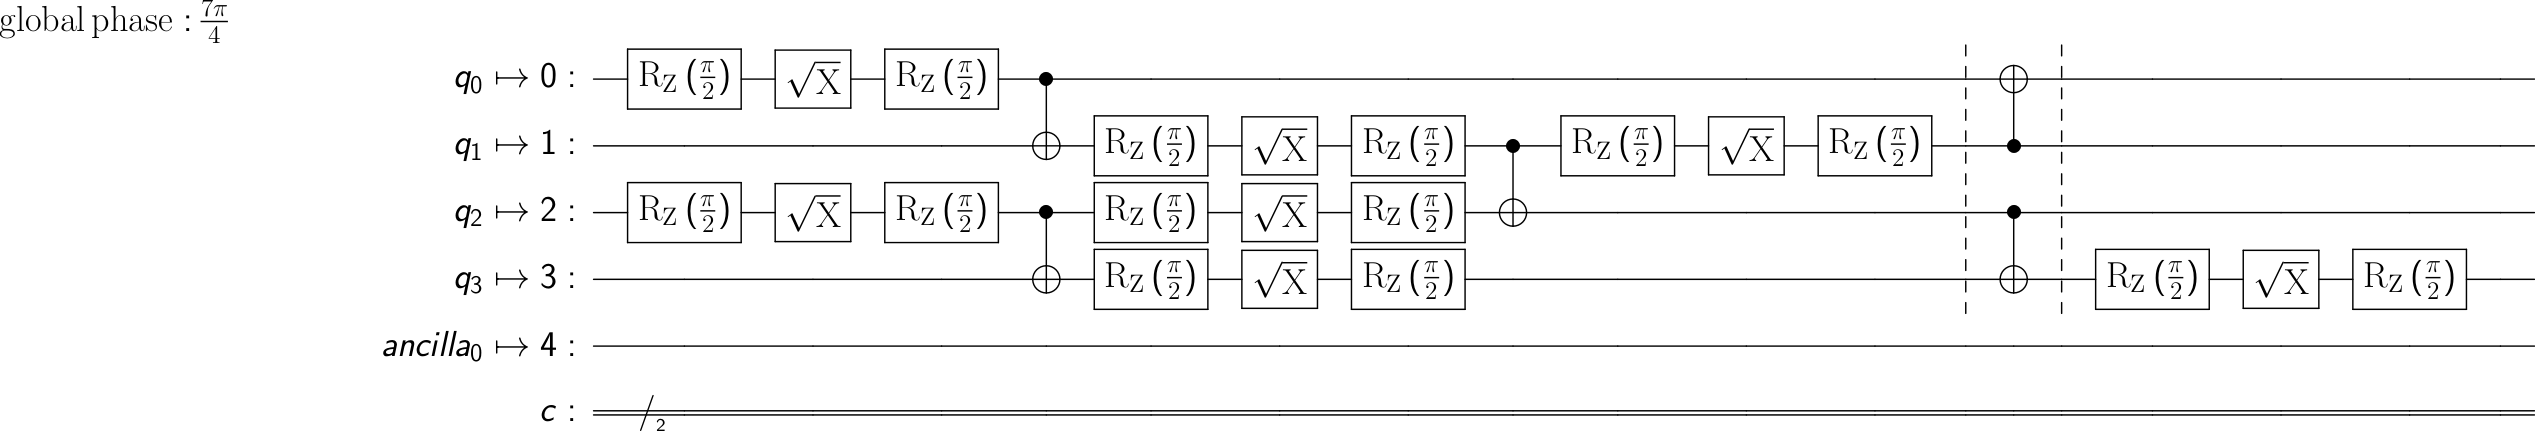

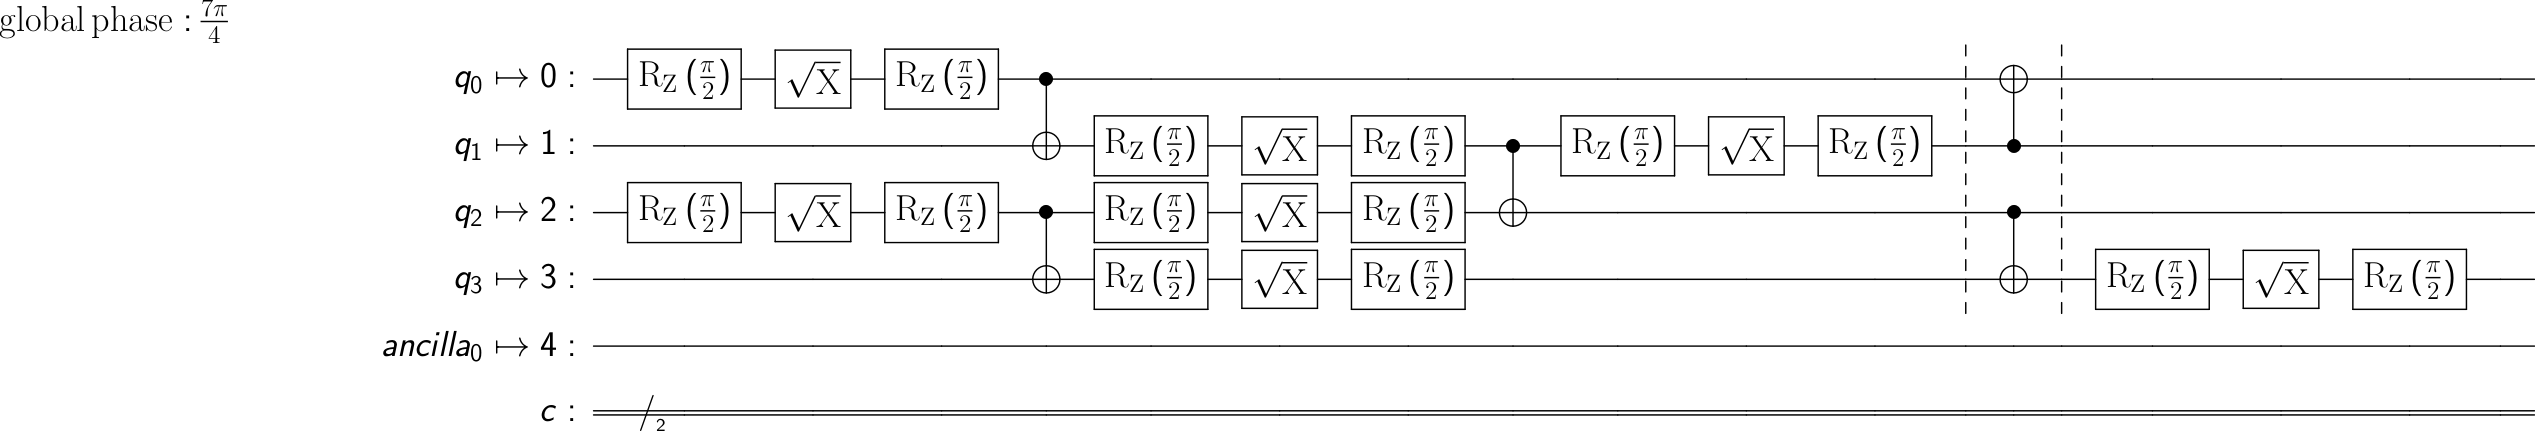

None

None

None

None

In [13]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]

display(tqc_Bell_b.draw('latex'),
        tqc_Bell_sim_b.draw('latex'),
        print("Vector de estado del Circuito para el estado de Bell usando el sistema real:\n ",
              tqc_Bell_b_sv),
        print("\n\nVector de estado del Circuito para el estado de Bell usando el modelo de prueba:\n ",
              tqc_Bell_sim_b_sv),
        print("\n\nProfundidad del Circuito para el estado de Bell usando el sistema real:\n ",
              tqc_Bell_b.depth()),
        print("\n\nProfundidad del Circuito para el estado de Bell usando el modelo de prueba:\n ",
              tqc_Bell_sim_b.depth()))


Vector de estado del Circuito para el estado de Bell usando el sistema real:
  Statevector([3.53553391e-01+0.00000000e+00j,
             0.00000000e+00+1.57009246e-16j,
             3.53553391e-01-1.66533454e-16j,
             0.00000000e+00+1.57009246e-16j,
             3.53553391e-01+0.00000000e+00j,
             0.00000000e+00+1.57009246e-16j,
             3.53553391e-01-1.66533454e-16j,
             0.00000000e+00+1.57009246e-16j,
             9.81307787e-18+1.66822324e-16j,
             3.53553391e-01-4.44089210e-16j,
             9.81307787e-18+1.66822324e-16j,
             3.53553391e-01-3.33066907e-16j,
             9.81307787e-18+1.66822324e-16j,
             3.53553391e-01-4.44089210e-16j,
             9.81307787e-18+1.66822324e-16j,
             3.53553391e-01-3.33066907e-16j,
             0.00000000e+00+0.00000000e+00j,
             0.00000000e+00+0.00000000e+00j,
             0.00000000e+00+0.00000000e+00j,
             0.00000000e+00+0.00000000e+00j,
             0.000000

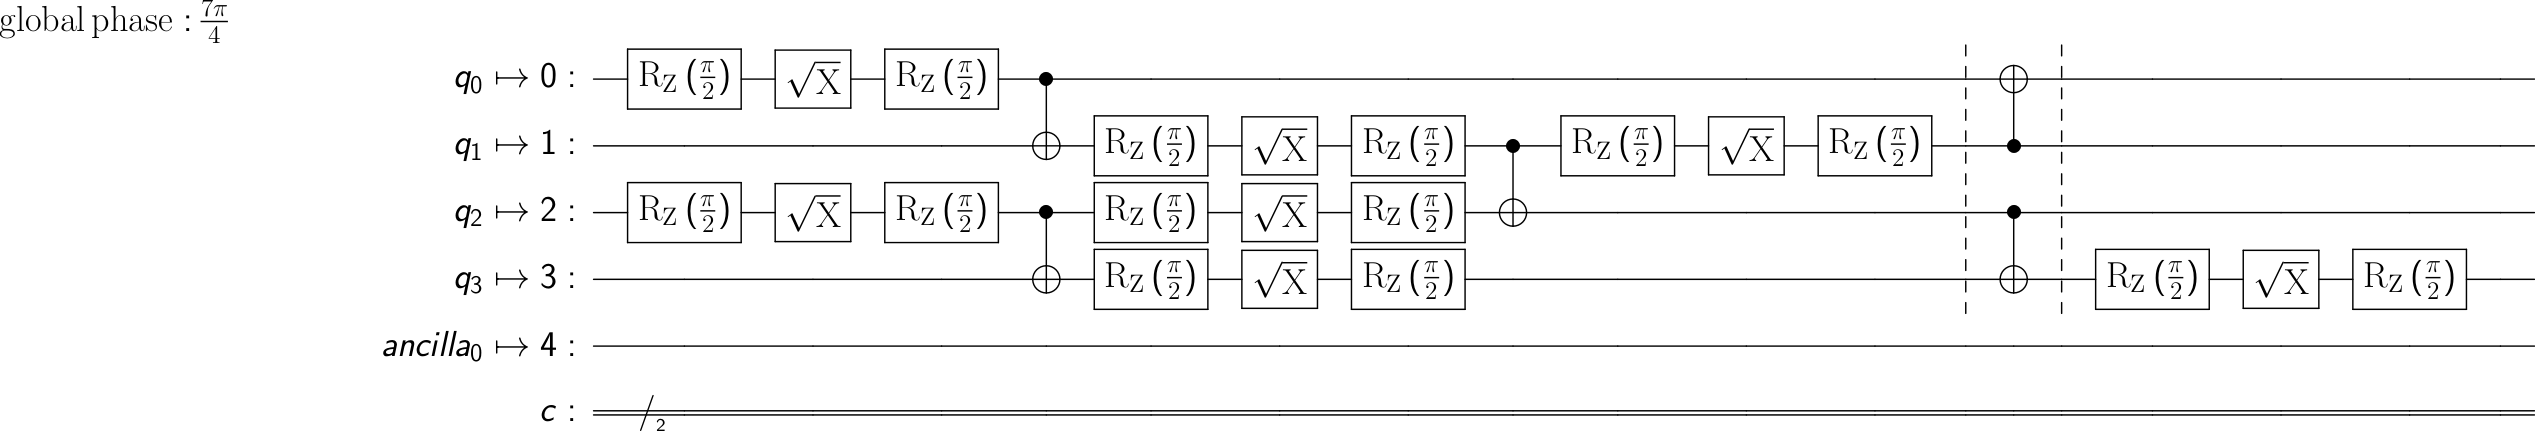

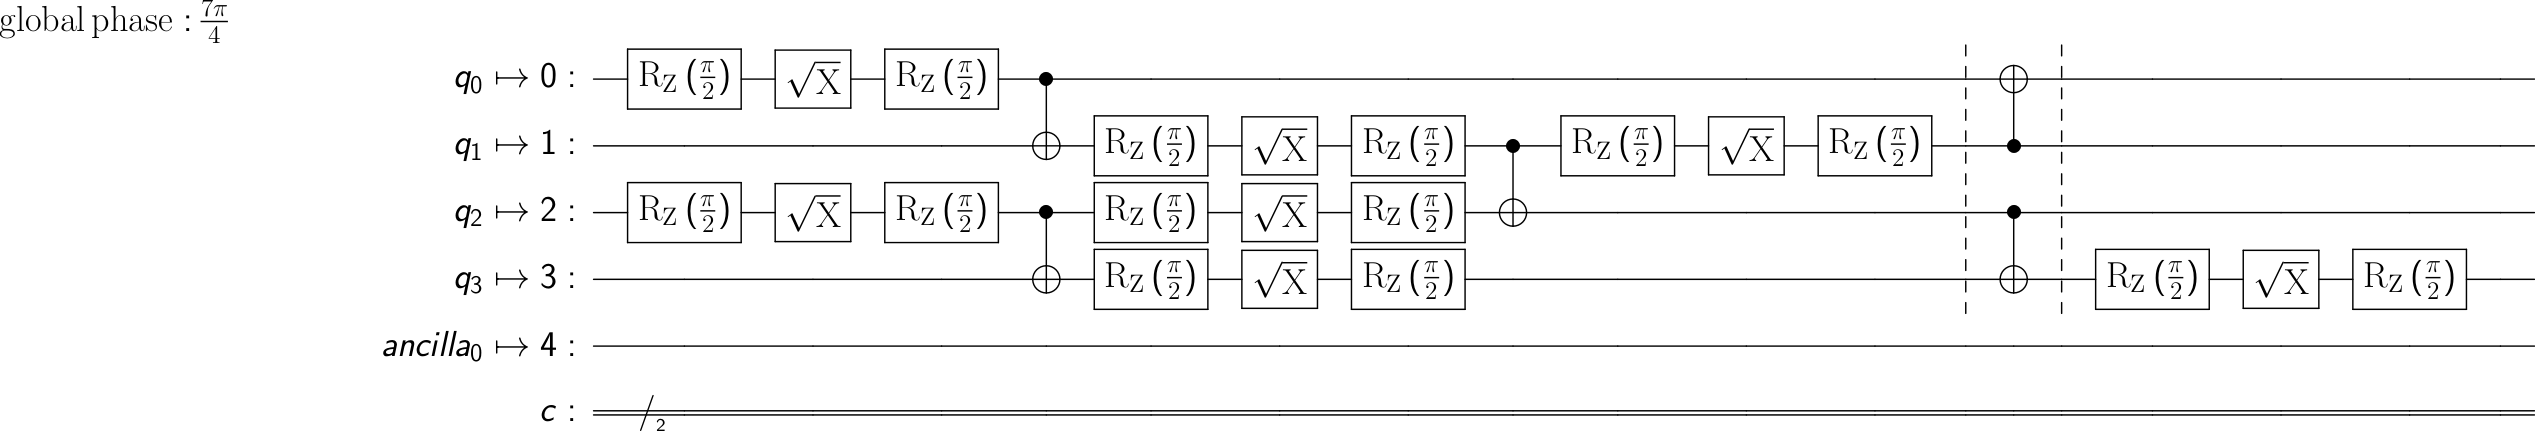

None

None

None

None

In [14]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]

display(tqc_Bell_s.draw('latex'),
        tqc_Bell_sim_s.draw('latex'),
        print("Vector de estado del Circuito para el estado de Bell usando el sistema real:\n ",
              tqc_Bell_s_sv),
        print("\n\nVector de estado del Circuito para el estado de Bell usando el modelo de prueba:\n ",
              tqc_Bell_sim_s_sv),
        print("\n\nProfundidad del Circuito para el estado de Bell usando el sistema real:\n ",
              tqc_Bell_s.depth()),
        print("\n\nProfundidad del Circuito para el estado de Bell usando el modelo de prueba:\n ",
              tqc_Bell_sim_s.depth()))


Vector de estado del Circuito para el estado de Bell usando el sistema real:
  Statevector([3.53553391e-01+0.00000000e+00j,
             0.00000000e+00+1.57009246e-16j,
             3.53553391e-01-1.66533454e-16j,
             0.00000000e+00+1.57009246e-16j,
             3.53553391e-01+0.00000000e+00j,
             0.00000000e+00+1.57009246e-16j,
             3.53553391e-01-1.66533454e-16j,
             0.00000000e+00+1.57009246e-16j,
             9.81307787e-18+1.66822324e-16j,
             3.53553391e-01-4.44089210e-16j,
             9.81307787e-18+1.66822324e-16j,
             3.53553391e-01-3.33066907e-16j,
             9.81307787e-18+1.66822324e-16j,
             3.53553391e-01-4.44089210e-16j,
             9.81307787e-18+1.66822324e-16j,
             3.53553391e-01-3.33066907e-16j,
             0.00000000e+00+0.00000000e+00j,
             0.00000000e+00+0.00000000e+00j,
             0.00000000e+00+0.00000000e+00j,
             0.00000000e+00+0.00000000e+00j,
             0.000000

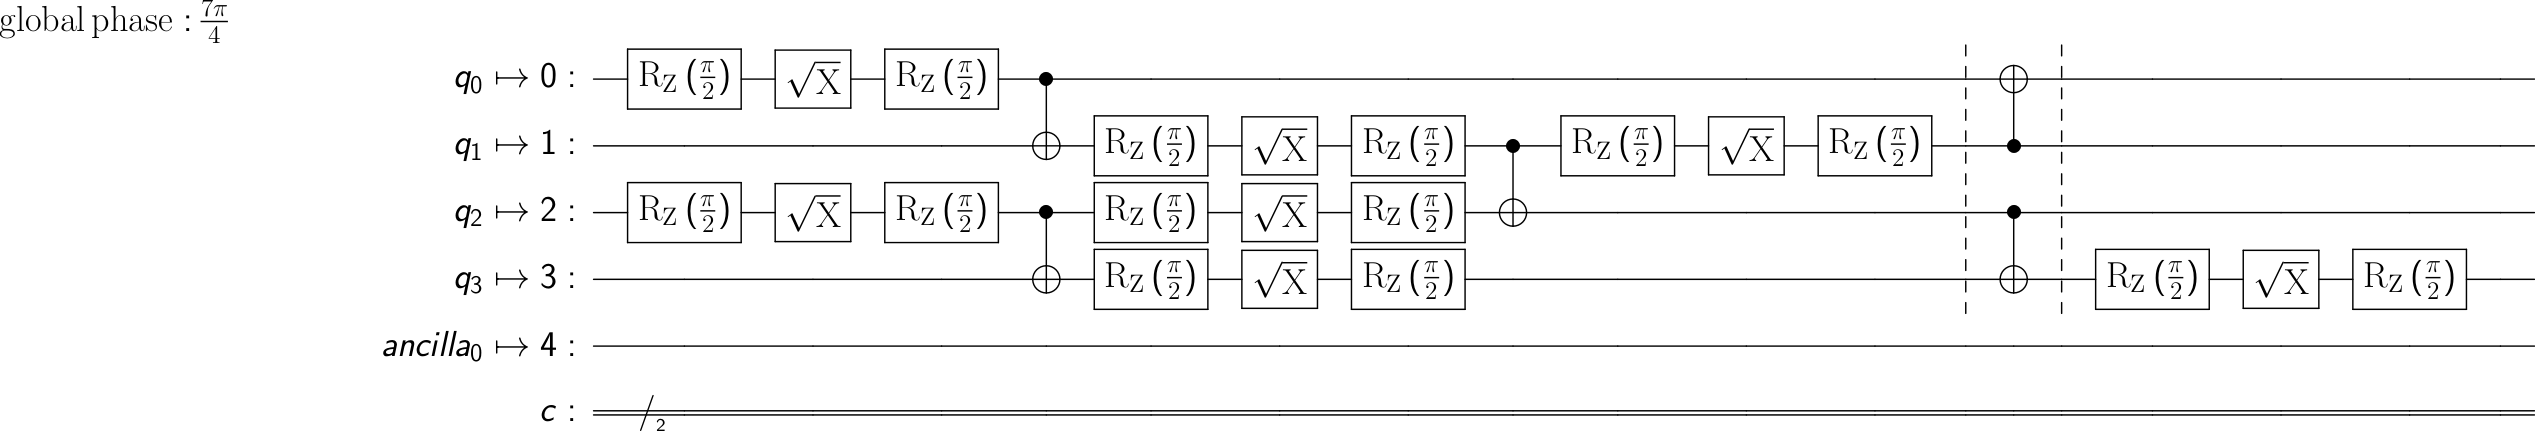

None

None

In [15]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]

display(tqc_Bell_m.draw('latex'),
        print("Vector de estado del Circuito para el estado de Bell usando el sistema real:\n ",
              tqc_Bell_m_sv),
        print("\n\nProfundidad del Circuito para el estado de Bell usando el sistema real:\n ",
              tqc_Bell_m.depth()))


Vector de estado del Circuito para el estado de GHZ usando el sistema real:
  Statevector([ 3.53553391e-01+2.77555756e-17j,
             -4.93038066e-32+7.85046229e-17j,
              3.53553391e-01-2.77555756e-17j,
             -6.77927340e-32+7.85046229e-17j,
             -4.93038066e-32+7.85046229e-17j,
              0.00000000e+00+1.57009246e-16j,
             -7.39557099e-32+7.85046229e-17j,
             -3.92523115e-17+1.96261557e-16j,
              3.53553391e-01+2.77555756e-17j,
             -4.93038066e-32+7.85046229e-17j,
              3.53553391e-01-2.77555756e-17j,
             -6.77927340e-32+7.85046229e-17j,
             -4.93038066e-32+7.85046229e-17j,
              0.00000000e+00+1.57009246e-16j,
             -7.39557099e-32+7.85046229e-17j,
             -3.92523115e-17+1.96261557e-16j,
              9.81307787e-18+1.27570012e-16j,
             -1.23259516e-32+7.85046229e-17j,
             -9.81307787e-18+1.27570012e-16j,
             -3.69778549e-32+9.81307787e-17j,
  

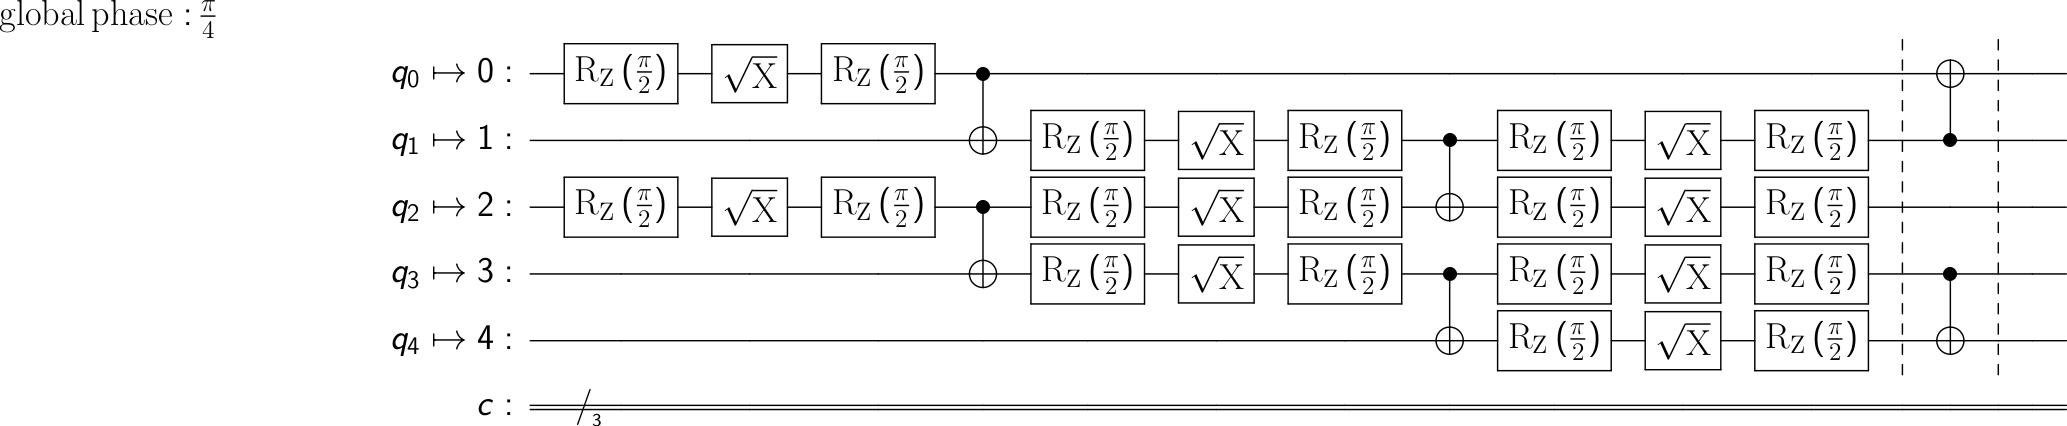

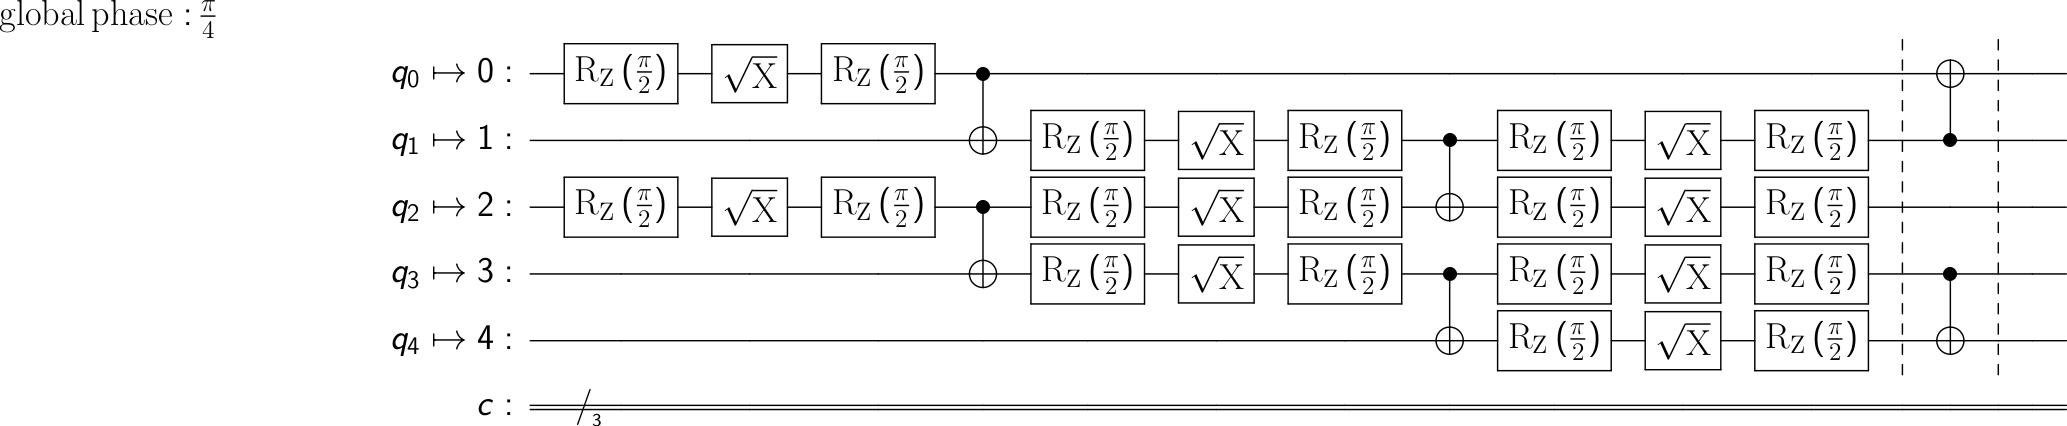

None

None

None

None

In [16]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]

display(tqc_GHZ_b.draw('latex'),
        tqc_GHZ_sim_b.draw('latex'),
        print("Vector de estado del Circuito para el estado de GHZ usando el sistema real:\n ",
              tqc_GHZ_b_sv),
        print("\n\nVector de estado del Circuito para el estado de GHZ usando el modelo de prueba:\n ",
              tqc_GHZ_sim_b_sv),
        print("\n\nProfundidad del Circuito para el estado de GHZ usando el sistema real:\n ",
              tqc_GHZ_b.depth()),
        print("\n\nProfundidad del Circuito para el estado de GHZ usando el modelo de prueba:\n ",
              tqc_GHZ_sim_b.depth()))


Vector de estado del Circuito para el estado de GHZ usando el sistema real:
  Statevector([ 3.53553391e-01+2.77555756e-17j,
             -4.93038066e-32+7.85046229e-17j,
              3.53553391e-01-2.77555756e-17j,
             -6.77927340e-32+7.85046229e-17j,
             -4.93038066e-32+7.85046229e-17j,
              0.00000000e+00+1.57009246e-16j,
             -7.39557099e-32+7.85046229e-17j,
             -3.92523115e-17+1.96261557e-16j,
              3.53553391e-01+2.77555756e-17j,
             -4.93038066e-32+7.85046229e-17j,
              3.53553391e-01-2.77555756e-17j,
             -6.77927340e-32+7.85046229e-17j,
             -4.93038066e-32+7.85046229e-17j,
              0.00000000e+00+1.57009246e-16j,
             -7.39557099e-32+7.85046229e-17j,
             -3.92523115e-17+1.96261557e-16j,
              9.81307787e-18+1.27570012e-16j,
             -1.23259516e-32+7.85046229e-17j,
             -9.81307787e-18+1.27570012e-16j,
             -3.69778549e-32+9.81307787e-17j,
  

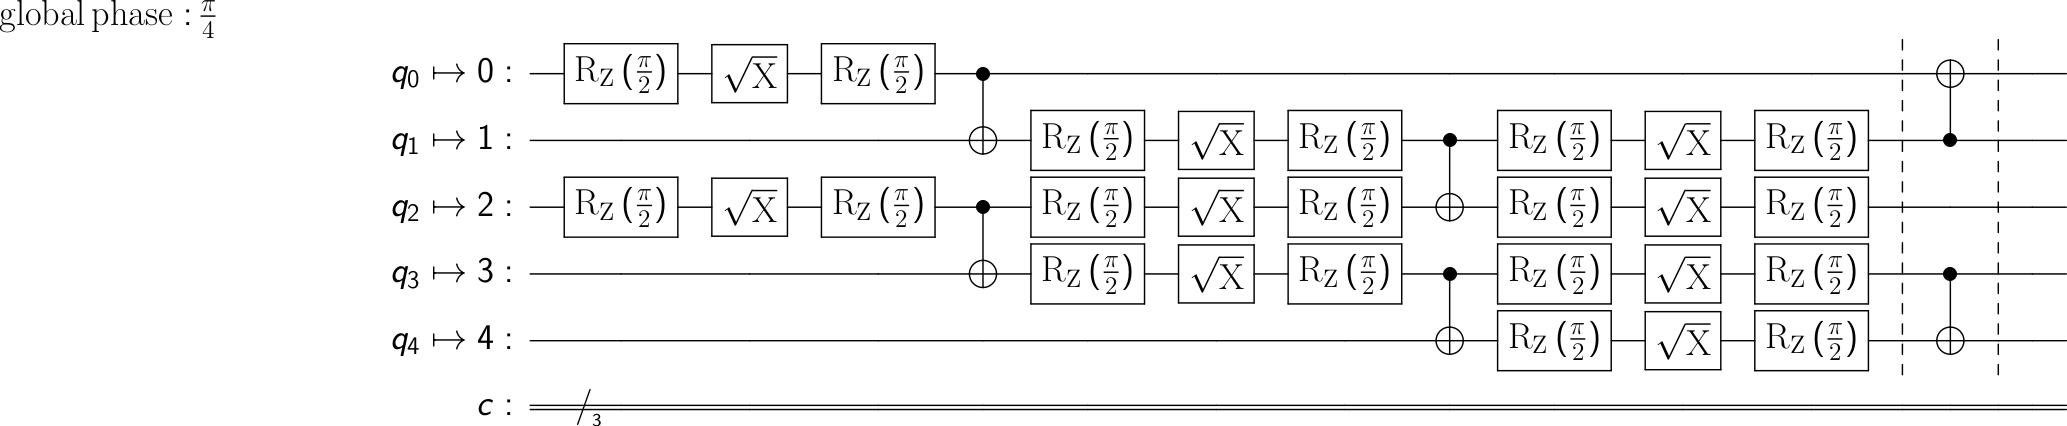

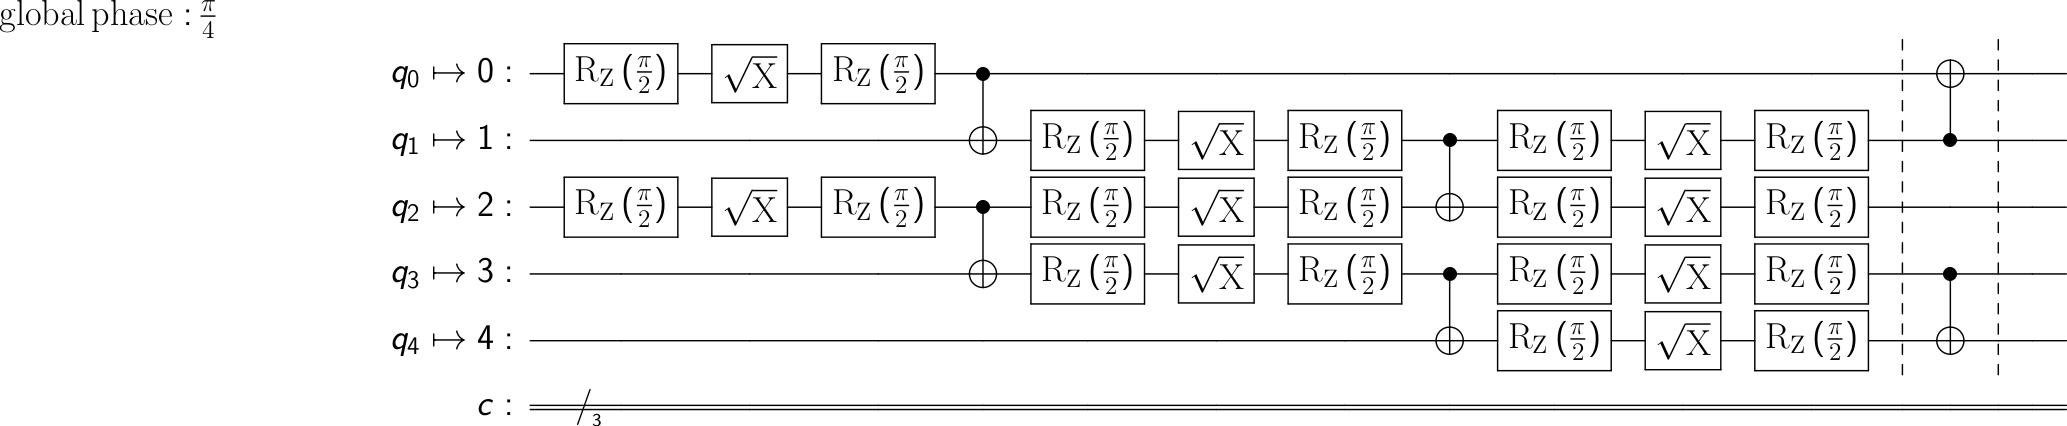

None

None

None

None

In [17]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]

display(tqc_GHZ_s.draw('latex'),
        tqc_GHZ_sim_s.draw('latex'),
        print("Vector de estado del Circuito para el estado de GHZ usando el sistema real:\n ",
              tqc_GHZ_s_sv),
        print("\n\nVector de estado del Circuito para el estado de GHZ usando el modelo de prueba:\n ",
              tqc_GHZ_sim_s_sv),
        print("\n\nProfundidad del Circuito para el estado de GHZ usando el sistema real:\n ",
              tqc_GHZ_s.depth()),
        print("\n\nProfundidad del Circuito para el estado de GHZ usando el modelo de prueba:\n ",
              tqc_GHZ_sim_s.depth()))


Vector de estado del Circuito para el estado de GHZ usando el sistema real:
  Statevector([ 3.53553391e-01+2.77555756e-17j,
             -4.93038066e-32+7.85046229e-17j,
              3.53553391e-01-2.77555756e-17j,
             -6.77927340e-32+7.85046229e-17j,
             -4.93038066e-32+7.85046229e-17j,
              0.00000000e+00+1.57009246e-16j,
             -7.39557099e-32+7.85046229e-17j,
             -3.92523115e-17+1.96261557e-16j,
              3.53553391e-01+2.77555756e-17j,
             -4.93038066e-32+7.85046229e-17j,
              3.53553391e-01-2.77555756e-17j,
             -6.77927340e-32+7.85046229e-17j,
             -4.93038066e-32+7.85046229e-17j,
              0.00000000e+00+1.57009246e-16j,
             -7.39557099e-32+7.85046229e-17j,
             -3.92523115e-17+1.96261557e-16j,
              9.81307787e-18+1.27570012e-16j,
             -1.23259516e-32+7.85046229e-17j,
             -9.81307787e-18+1.27570012e-16j,
             -3.69778549e-32+9.81307787e-17j,
  

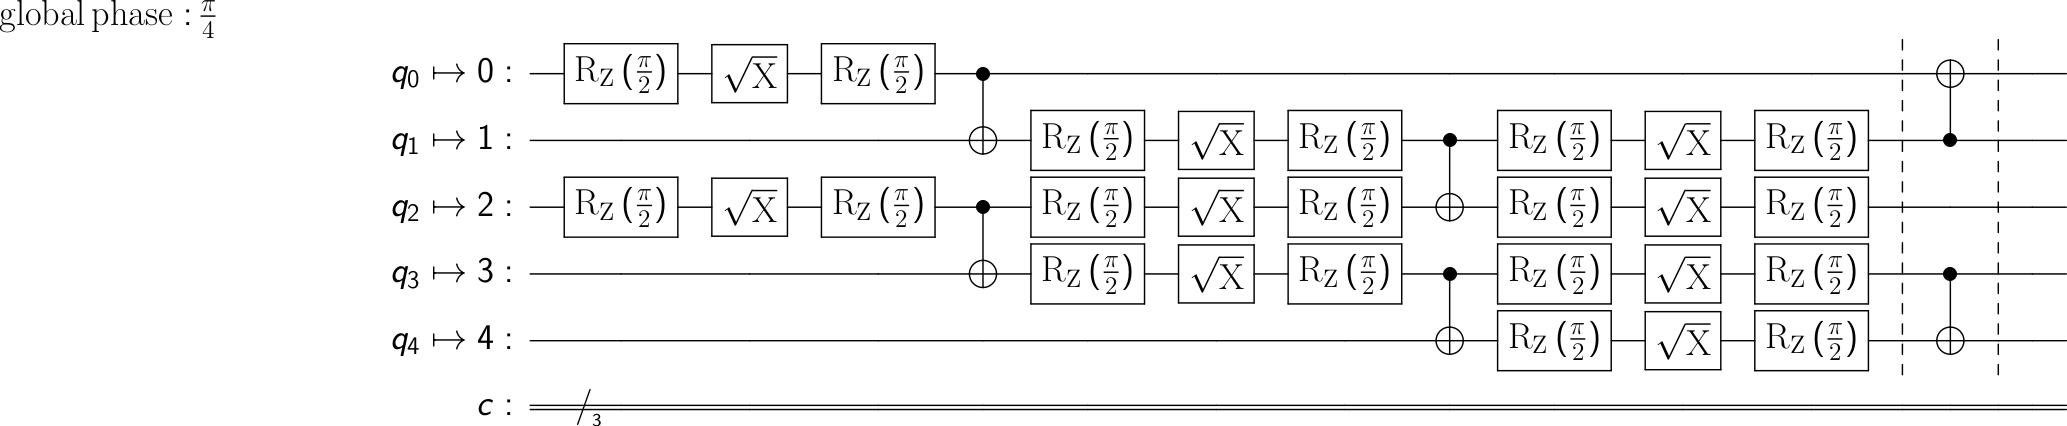

None

None

In [18]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]

display(tqc_GHZ_m.draw('latex'),
        print("Vector de estado del Circuito para el estado de GHZ usando el sistema real:\n ",
              tqc_GHZ_m_sv),
        print("\n\nProfundidad del Circuito para el estado de GHZ usando el sistema real:\n ",
              tqc_GHZ_m.depth()))


In [22]:
# Bell State
#qiskit.execute(tqc_Bell_b_meas, backend=qcomp_B, shots=shots)
#qiskit.execute(tqc_Bell_s_meas, backend=qcomp_S, shots=shots)
#qiskit.execute(tqc_Bell_m_meas, backend=qcomp_M, shots=shots)

# GHZ State
#qiskit.execute(tqc_GHZ_b_meas, backend=qcomp_B, shots=shots)
#qiskit.execute(tqc_GHZ_s_meas, backend=qcomp_S, shots=shots)
#qiskit.execute(tqc_GHZ_m_meas, backend=qcomp_M, shots=shots)


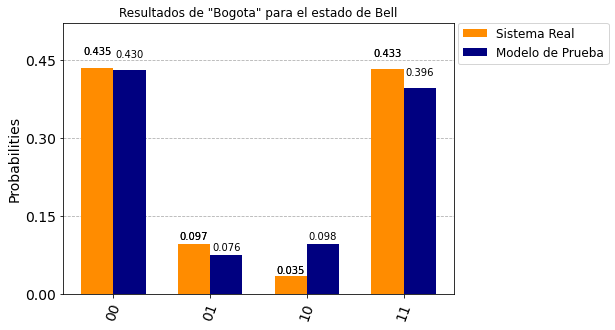

In [13]:
# Execute circuit on Bogota system
counts_Bell_b = qcomp_B.retrieve_job('61ad0622a880fe5328645b9a').result().get_counts()

# Execute noisy simulation on dummys
counts_Bell_sim_b = qcomp_sim_B.run(tqc_Bell_sim_b_meas, shots=shots).result().get_counts(tqc_Bell_sim_b_meas)

plth(
    [counts_Bell_b,
     counts_Bell_sim_b
    ],
    legend=['Sistema Real',
            'Modelo de Prueba'
           ],
    title='Resultados de "Bogota" para el estado de Bell',
    color=['darkorange',
           'navy'
          ],
    figsize=(7, 5)
)

In [38]:
print('Cuentas de la codificación para el estado de Bell en el sistema real "Bogota": \n',counts_Bell_b)
for i in counts_Bell_b:
    print(i, ': ',counts_Bell_b[i], '/',counts_Bell_b[i]/shots)
print('\nCuentas de la codificación para el estado de Bell en el sistema de prueba: \n',counts_Bell_sim_b)
for i in counts_Bell_sim_b:
    print(i, ': ',counts_Bell_sim_b[i], '/',counts_Bell_sim_b[i]/shots)
    

Cuentas de la codificación para el estado de Bell en el sistema real "Bogota": 
 {'00': 3564, '01': 796, '10': 288, '11': 3544}
00 :  3564 / 0.43505859375
01 :  796 / 0.09716796875
10 :  288 / 0.03515625
11 :  3544 / 0.4326171875

Cuentas de la codificación para el estado de Bell en el sistema de prueba: 
 {'00': 3524, '11': 3245, '01': 624, '10': 799}
00 :  3524 / 0.43017578125
11 :  3245 / 0.3961181640625
01 :  624 / 0.076171875
10 :  799 / 0.0975341796875


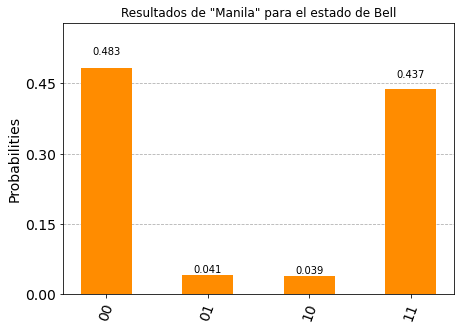

In [16]:
# Execute circuit on Manila system
counts_Bell_m = qcomp_M.retrieve_job('61ad0624d73dea555337370d').result().get_counts()

plth(
    [counts_Bell_m
    ],
    title='Resultados de "Manila" para el estado de Bell',
    color=['darkorange',
          ],
    figsize=(7, 5)
)

In [39]:
print('Cuentas de la codificación para el estado de Bell en el sistema real "Manila": \n',counts_Bell_m)
for i in counts_Bell_m:
    print(i, ': ',counts_Bell_m[i], '/',counts_Bell_m[i]/shots)
    

Cuentas de la codificación para el estado de Bell en el sistema real "Manila": 
 {'00': 3957, '01': 332, '10': 321, '11': 3582}
00 :  3957 / 0.4830322265625
01 :  332 / 0.04052734375
10 :  321 / 0.0391845703125
11 :  3582 / 0.437255859375


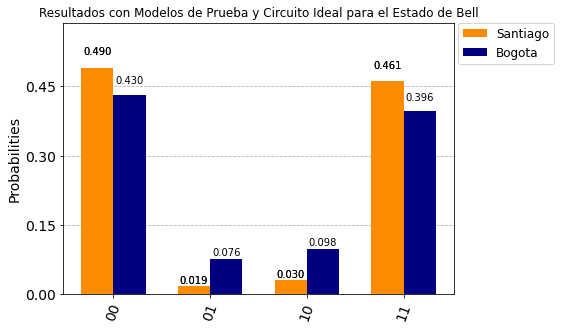

In [18]:
# Execute noisy simulation on dummys
counts_Bell_sim_s = qcomp_sim_S.run(tqc_Bell_sim_s_meas, shots=shots).result().get_counts(tqc_Bell_sim_s_meas)

plth(
    [counts_Bell_sim_s,
     counts_Bell_sim_b
    ],
    legend=['Santiago',
            'Bogota'
           ],
    title='Resultados con Modelos de Prueba y Circuito Ideal para el Estado de Bell',
    color=['darkorange',
           'navy'
          ],
    figsize=(7, 5)
)

In [40]:
print('Cuentas de la codificación para el estado de Bell en el modelo de prueba de "Bogota": \n',counts_Bell_sim_b)
for i in counts_Bell_sim_b:
    print(i, ': ',counts_Bell_sim_b[i], '/',counts_Bell_sim_b[i]/shots)
print('\nCuentas de la codificación para el estado de Bell en el modelo de prueba de "Santiago": \n',counts_Bell_sim_s)
for i in counts_Bell_sim_s:
    print(i, ': ',counts_Bell_sim_s[i], '/',counts_Bell_sim_s[i]/shots)


Cuentas de la codificación para el estado de Bell en el modelo de prueba de "Bogota": 
 {'00': 3524, '11': 3245, '01': 624, '10': 799}
00 :  3524 / 0.43017578125
11 :  3245 / 0.3961181640625
01 :  624 / 0.076171875
10 :  799 / 0.0975341796875

Cuentas de la codificación para el estado de Bell en el modelo de prueba de "Santiago": 
 {'11': 3778, '00': 4014, '01': 154, '10': 246}
11 :  3778 / 0.461181640625
00 :  4014 / 0.489990234375
01 :  154 / 0.018798828125
10 :  246 / 0.030029296875


In [46]:
for i in range(len(counts_Bell_sim_b)):
    print('{0:02b}'.format(i), ' ',counts_Bell_b['{0:02b}'.format(i)], '/',
          round(counts_Bell_b['{0:02b}'.format(i)]/shots, 5), ' ',
          counts_Bell_b['{0:02b}'.format(i)], '/',
          round(counts_Bell_sim_b['{0:02b}'.format(i)]/shots, 5), ' ',
          counts_Bell_sim_b['{0:02b}'.format(i)], '/',
          round(counts_Bell_m['{0:02b}'.format(i)]/shots, 5), ' ',
          counts_Bell_m['{0:02b}'.format(i)], '/',
          round(counts_Bell_sim_s['{0:02b}'.format(i)]/shots, 5)
         )

00   3564 / 0.43506   3564 / 0.43018   3524 / 0.48303   3957 / 0.48999
01   796 / 0.09717   796 / 0.07617   624 / 0.04053   332 / 0.0188
10   288 / 0.03516   288 / 0.09753   799 / 0.03918   321 / 0.03003
11   3544 / 0.43262   3544 / 0.39612   3245 / 0.43726   3582 / 0.46118


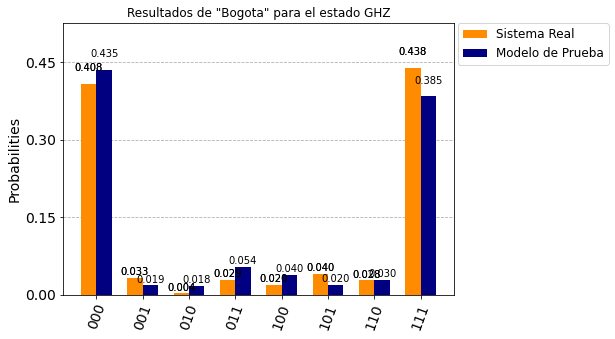

In [20]:
# Execute circuit on Bogota system
counts_GHZ_b = qcomp_B.retrieve_job('61ad0625aad5f3f1cb9dbe18').result().get_counts()

# Execute noisy simulation on dummys
counts_GHZ_sim_b = qcomp_sim_B.run(tqc_GHZ_sim_b_meas, shots=shots).result().get_counts(tqc_GHZ_sim_b_meas)

plth(
    [counts_GHZ_b,
     counts_GHZ_sim_b
    ],
    legend=['Sistema Real',
            'Modelo de Prueba'
           ],
    title='Resultados de "Bogota" para el estado GHZ',
    color=['darkorange',
           'navy'
          ],
    figsize=(7, 5)
)

In [41]:
print('Cuentas de la codificación para el estado GHZ en el sistema real "Bogota": \n',counts_GHZ_b)
for i in counts_GHZ_b:
    print(i, ': ',counts_GHZ_b[i], '/',counts_GHZ_b[i]/shots)
print('\nCuentas de la codificación para el estado GHZ en el sistema de prueba: \n',counts_GHZ_sim_b)
for i in counts_GHZ_sim_b:
    print(i, ': ',counts_GHZ_sim_b[i], '/',counts_GHZ_sim_b[i]/shots)


Cuentas de la codificación para el estado GHZ en el sistema real "Bogota": 
 {'000': 3343, '001': 270, '010': 33, '011': 234, '100': 164, '101': 328, '110': 233, '111': 3587}
000 :  3343 / 0.4080810546875
001 :  270 / 0.032958984375
010 :  33 / 0.0040283203125
011 :  234 / 0.028564453125
100 :  164 / 0.02001953125
101 :  328 / 0.0400390625
110 :  233 / 0.0284423828125
111 :  3587 / 0.4378662109375

Cuentas de la codificación para el estado GHZ en el sistema de prueba: 
 {'000': 3564, '111': 3155, '100': 324, '110': 245, '010': 146, '011': 439, '001': 156, '101': 163}
000 :  3564 / 0.43505859375
111 :  3155 / 0.3851318359375
100 :  324 / 0.03955078125
110 :  245 / 0.0299072265625
010 :  146 / 0.017822265625
011 :  439 / 0.0535888671875
001 :  156 / 0.01904296875
101 :  163 / 0.0198974609375


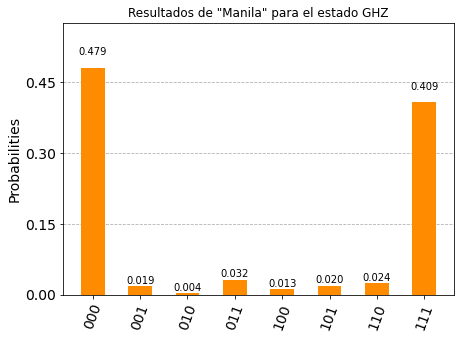

In [23]:
# Execute circuit on Manila system
counts_GHZ_m = qcomp_M.retrieve_job('61ad0627dcbe23e8d61942d2').result().get_counts()

plth(
    [counts_GHZ_m
    ],
    title='Resultados de "Manila" para el estado GHZ',
    color=['darkorange',
          ],
    figsize=(7, 5)
)

In [42]:
print('Cuentas de la codificación para el estado GHZ en el sistema real "Manila": \n',counts_GHZ_m)
for i in counts_GHZ_m:
    print(i, ': ',counts_GHZ_m[i], '/',counts_GHZ_m[i]/shots)

Cuentas de la codificación para el estado GHZ en el sistema real "Manila": 
 {'000': 3926, '001': 153, '010': 30, '011': 266, '100': 105, '101': 160, '110': 200, '111': 3352}
000 :  3926 / 0.479248046875
001 :  153 / 0.0186767578125
010 :  30 / 0.003662109375
011 :  266 / 0.032470703125
100 :  105 / 0.0128173828125
101 :  160 / 0.01953125
110 :  200 / 0.0244140625
111 :  3352 / 0.4091796875


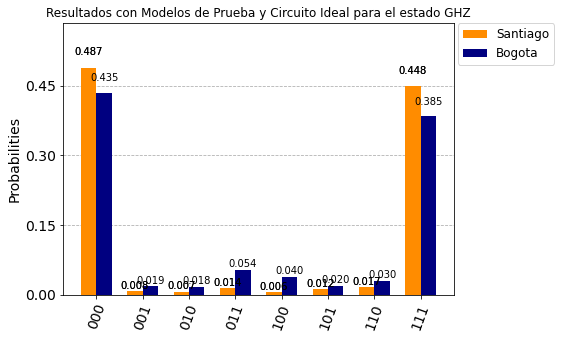

In [25]:
# Execute noisy simulation on dummys
counts_GHZ_sim_s = qcomp_sim_S.run(tqc_GHZ_sim_s_meas, shots=shots).result().get_counts(tqc_GHZ_sim_s_meas)

plth(
    [counts_GHZ_sim_s,
     counts_GHZ_sim_b
    ],
    legend=['Santiago',
            'Bogota'
           ],
    title='Resultados con Modelos de Prueba y Circuito Ideal para el estado GHZ',
    color=['darkorange',
           'navy'
          ],
    figsize=(7, 5)
)

In [43]:
print('Cuentas de la codificación para el estado GHZ en el modelo de prueba de "Bogota": \n',counts_GHZ_sim_b)
for i in counts_GHZ_sim_b:
    print(i, ': ',counts_GHZ_sim_b[i], '/',counts_GHZ_sim_b[i]/shots)
print('\nCuentas de la codificación para el estado GHZ en el modelo de prueba de "Santiago": \n',counts_GHZ_sim_s)
for i in counts_GHZ_sim_s:
    print(i, ': ',counts_GHZ_sim_s[i], '/',counts_GHZ_sim_s[i]/shots)


Cuentas de la codificación para el estado GHZ en el modelo de prueba de "Bogota": 
 {'000': 3564, '111': 3155, '100': 324, '110': 245, '010': 146, '011': 439, '001': 156, '101': 163}
000 :  3564 / 0.43505859375
111 :  3155 / 0.3851318359375
100 :  324 / 0.03955078125
110 :  245 / 0.0299072265625
010 :  146 / 0.017822265625
011 :  439 / 0.0535888671875
001 :  156 / 0.01904296875
101 :  163 / 0.0198974609375

Cuentas de la codificación para el estado GHZ en el modelo de prueba de "Santiago": 
 {'111': 3673, '000': 3989, '110': 141, '001': 65, '010': 59, '100': 48, '101': 100, '011': 117}
111 :  3673 / 0.4483642578125
000 :  3989 / 0.4869384765625
110 :  141 / 0.0172119140625
001 :  65 / 0.0079345703125
010 :  59 / 0.0072021484375
100 :  48 / 0.005859375
101 :  100 / 0.01220703125
011 :  117 / 0.0142822265625


In [47]:
for i in range(len(counts_GHZ_sim_b)):
    print('{0:03b}'.format(i), ' ',counts_GHZ_b['{0:03b}'.format(i)], '/',
          round(counts_GHZ_b['{0:03b}'.format(i)]/shots, 5), ' ',
          counts_GHZ_b['{0:03b}'.format(i)], '/',
          round(counts_GHZ_sim_b['{0:03b}'.format(i)]/shots, 5), ' ',
          counts_GHZ_sim_b['{0:03b}'.format(i)], '/',
          round(counts_GHZ_m['{0:03b}'.format(i)]/shots, 5), ' ',
          counts_GHZ_m['{0:03b}'.format(i)], '/',
          round(counts_GHZ_sim_s['{0:03b}'.format(i)]/shots, 5)
         )

000   3343 / 0.40808   3343 / 0.43506   3564 / 0.47925   3926 / 0.48694
001   270 / 0.03296   270 / 0.01904   156 / 0.01868   153 / 0.00793
010   33 / 0.00403   33 / 0.01782   146 / 0.00366   30 / 0.0072
011   234 / 0.02856   234 / 0.05359   439 / 0.03247   266 / 0.01428
100   164 / 0.02002   164 / 0.03955   324 / 0.01282   105 / 0.00586
101   328 / 0.04004   328 / 0.0199   163 / 0.01953   160 / 0.01221
110   233 / 0.02844   233 / 0.02991   245 / 0.02441   200 / 0.01721
111   3587 / 0.43787   3587 / 0.38513   3155 / 0.40918   3352 / 0.44836


In [36]:
t = time.time()

cal_Bell_id = ['61ac3d8fd73dea70d937350a']

tomo_Bell_id = ['61ad0acfaad5f32a379dbe29',
               '61ad0ad72e6f458d489c7eec',
               '61ad0d1adcbe234a4f1942e2']

P_Bell = tomo(qc=codBell(False),
              backend=qcomp_B,
              qubits=[0, 1, 2, 3, 4],
              cal_id=cal_Bell_id,
              tomo_id=tomo_Bell_id) 

F_Bell_b = qi.state_fidelity(P_Bell[0], tqc_Bell_b_sv)
F_Bell_b_mit = qi.state_fidelity(P_Bell[2], tqc_Bell_b_sv)
print('Fidelidad en "Bogota" para el estado de Bell (s/ corrección): F = {:.5f}'.format(F_Bell_b))
print('                                             (c/ corrección): F = {:.5f}'.format(F_Bell_b_mit))
print('\n\nTiempo de ejecución (s/ corrección): t = {:.5f}'.format(P_Bell[1]))
print('                    (c/ corrección): t = {:.5f}'.format(P_Bell[3]))
print('\n\nTiempo transcurrido: t = {:.5f}'.format(time.time() - t))


Fidelidad en "Bogota" para el estado de Bell (s/ corrección): F = 0.72710
                                             (c/ corrección): F = 0.87165


Tiempo de ejecución (s/ corrección): t = 9.40182
                    (c/ corrección): t = 10.69756


Tiempo transcurrido: t = 43.02481


In [37]:
t = time.time()

cal_Bell_id = ['61ac3d76fd942634d6c6f9c5']

tomo_Bell_id = ['61ad0e76bf8803f738309933',
               '61ad0e802e6f4523c89c7ef6',
               '61ad150cdcbe2353d81942f7']

P_Bell = tomo(qc=codBell(False),
              backend=qcomp_M,
              qubits=[0, 1, 2, 3, 4],
              cal_id=cal_Bell_id,
              tomo_id=tomo_Bell_id) 

F_Bell_m = qi.state_fidelity(P_Bell[0], tqc_Bell_m_sv)
F_Bell_m_mit = qi.state_fidelity(P_Bell[2], tqc_Bell_m_sv)
print('Fidelidad en "Manila" para el estado de Bell (s/ corrección): F = {:.5f}'.format(F_Bell_m))
print('                                             (c/ corrección): F = {:.5f}'.format(F_Bell_m_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_Bell[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_Bell[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en "Manila" para el estado de Bell (s/ corrección): F = 0.80153
                                             (c/ corrección): F = 0.91335


Tiempo de ejecución [minutos] (s/ corrección): t = 9.27640
                              (c/ corrección): t = 10.53792


Tiempo transcurrido [segundos] : t = 43.51061


In [38]:
t = time.time()

P_Bell_sim = tomo(qc=codBell(False),
              backend=qcomp_sim_B,
              qubits=[0, 1, 2, 3, 4]) 

F_Bell_sim_b = qi.state_fidelity(P_Bell_sim[0], tqc_Bell_sim_b_sv)
F_Bell_sim_b_mit = qi.state_fidelity(P_Bell_sim[2], tqc_Bell_sim_b_sv)
print('Fidelidad en el Modelo de prueba de "Bogota" para el estado de Bell (s/ corrección): F = {:.5f}'.format(F_Bell_sim_b))
print('                                                                    (c/ corrección): F = {:.5f}'.format(F_Bell_sim_b_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_Bell[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_Bell[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de prueba de "Bogota" para el estado de Bell (s/ corrección): F = 0.65572
                                                                    (c/ corrección): F = 0.79958


Tiempo de ejecución [minutos] (s/ corrección): t = 9.27640
                              (c/ corrección): t = 10.53792


Tiempo transcurrido [segundos] : t = 52.89222


In [39]:
t = time.time()

P_Bell_sim = tomo(qc=codBell(False),
              backend=qcomp_sim_S,
              qubits=[0, 1, 2, 3, 4]) 

F_Bell_sim_s = qi.state_fidelity(P_Bell_sim[0], tqc_Bell_sim_s_sv)
F_Bell_sim_s_mit = qi.state_fidelity(P_Bell_sim[2], tqc_Bell_sim_s_sv)
print('Fidelidad en el Modelo de prueba de "Santiago" para el estado de Bell (s/ corrección): F = {:.5f}'.format(F_Bell_sim_s))
print('                                                                          (c/ corrección): F = {:.5f}'.format(F_Bell_sim_s_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_Bell[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_Bell[3]))
print('Tiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de prueba de "Santiago" para el estado de Bell (s/ corrección): F = 0.89800
                                                                          (c/ corrección): F = 0.96750


Tiempo de ejecución [minutos] (s/ corrección): t = 9.27640
                              (c/ corrección): t = 10.53792
Tiempo transcurrido [segundos] : t = 38.44153


In [40]:
t = time.time()

cal_GHZ_id = ['61ac3d8fd73dea70d937350a']

tomo_GHZ_id = []

P_GHZ = tomo(qc=codGHZ(False),
              backend=qcomp_B,
              qubits=[0, 1, 2, 3, 4],
              cal_id=cal_GHZ_id,
              tomo_id=tomo_GHZ_id) 

F_GHZ_b = qi.state_fidelity(P_GHZ[0], tqc_GHZ_b_sv)
F_GHZ_b_mit = qi.state_fidelity(P_GHZ[2], tqc_GHZ_b_sv)
print('Fidelidad en "Bogota" para el estado GHZ (s/ corrección): F = {:.5f}'.format(F_GHZ_b))
print('                                         (c/ corrección): F = {:.5f}'.format(F_GHZ_b_mit))
print('\n\nTiempo de ejecución (s/ corrección): t = {:.5f}'.format(P_GHZ[1]))
print('                    (c/ corrección): t = {:.5f}'.format(P_GHZ[3]))
print('\n\nTiempo transcurrido: t = {:.5f}'.format(time.time() - t))


Fidelidad en "Bogota" para el estado GHZ (s/ corrección): F = 0.76384
                                             (c/ corrección): F = 0.88716


Tiempo de ejecución (s/ corrección): t = 9.43578
                    (c/ corrección): t = 10.73152


Tiempo transcurrido: t = 646.07316


In [41]:
t = time.time()

cal_GHZ_id = ['61ac3d76fd942634d6c6f9c5']

tomo_GHZ_id = []

P_GHZ = tomo(qc=codGHZ(False),
              backend=qcomp_M,
              qubits=[0, 1, 2, 3, 4],
              cal_id=cal_GHZ_id,
              tomo_id=tomo_GHZ_id) 

F_GHZ_m = qi.state_fidelity(P_GHZ[0], tqc_GHZ_m_sv)
F_GHZ_m_mit = qi.state_fidelity(P_GHZ[2], tqc_GHZ_m_sv)
print('Fidelidad en "Manila" para el estado GHZ (s/ corrección): F = {:.5f}'.format(F_GHZ_m))
print('                                         (c/ corrección): F = {:.5f}'.format(F_GHZ_m_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_GHZ[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_GHZ[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en "Manila" para el estado GHZ (s/ corrección): F = 0.81300
                                             (c/ corrección): F = 0.92351


Tiempo de ejecución [minutos] (s/ corrección): t = 9.30141
                              (c/ corrección): t = 10.56234


Tiempo transcurrido [segundos] : t = 4110.33216


In [42]:
t = time.time()

P_GHZ_sim = tomo(qc=codGHZ(False),
              backend=qcomp_sim_B,
              qubits=[0, 1, 2, 3, 4]) 

F_GHZ_sim_b = qi.state_fidelity(P_GHZ_sim[0], tqc_GHZ_sim_b_sv)
F_GHZ_sim_b_mit = qi.state_fidelity(P_GHZ_sim[2], tqc_GHZ_sim_b_sv)
print('Fidelidad en el Modelo de prueba de "Bogota" para el estado GHZ (s/ corrección): F = {:.5f}'.format(F_GHZ_sim_b))
print('                                                                (c/ corrección): F = {:.5f}'.format(F_GHZ_sim_b_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_GHZ[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_GHZ[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de prueba de "Bogota" para el estado GHZ (s/ corrección): F = 0.67619
                                                                    (c/ corrección): F = 0.85706


Tiempo de ejecución [minutos] (s/ corrección): t = 9.30141
                              (c/ corrección): t = 10.56234


Tiempo transcurrido [segundos] : t = 36.55617


In [43]:
t = time.time()

P_GHZ_sim = tomo(qc=codGHZ(False),
              backend=qcomp_sim_S,
              qubits=[0, 1, 2, 3, 4]) 

F_GHZ_sim_s = qi.state_fidelity(P_GHZ_sim[0], tqc_GHZ_sim_s_sv)
F_GHZ_sim_s_mit = qi.state_fidelity(P_GHZ_sim[2], tqc_GHZ_sim_s_sv)
print('Fidelidad en el Modelo de prueba de "Santiago" para el estado GHZ (s/ corrección): F = {:.5f}'.format(F_GHZ_sim_s))
print('                                                                  (c/ corrección): F = {:.5f}'.format(F_GHZ_sim_s_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_GHZ[1]))
print('                                  (c/ corrección): t = {:.5f}'.format(P_GHZ[3]))
print('Tiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de prueba de "Santiago" para el estado GHZ (s/ corrección): F = 0.87700
                                                                  (c/ corrección): F = 0.96363


Tiempo de ejecución [minutos] (s/ corrección): t = 9.30141
                                  (c/ corrección): t = 10.56234
Tiempo transcurrido [segundos] : t = 51.06631


In [17]:
# RUIDOS Clásicos

noisy_amp = amp_noise(p=p_amp)

noisy_phs = phs_noise(p=p_phs)

noisy_dprz = dprz_noise(p=p_dprz)

print(noisy_amp)
print(noisy_phs)
print(noisy_dprz)


NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'rz', 'sx', 'u3', 'x']
  Instructions with noise: ['cx', 'rz', 'sx', 'u3', 'x', 'cz']
  All-qubits errors: ['rz', 'sx', 'x', 'u3', 'cx', 'cz']
NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'rz', 'sx', 'u3', 'x']
  Instructions with noise: ['cx', 'rz', 'sx', 'u3', 'x', 'cz']
  All-qubits errors: ['rz', 'sx', 'x', 'u3', 'cx', 'cz']
NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'rz', 'sx', 'u3', 'x']
  Instructions with noise: ['cx', 'rz', 'sx', 'u3', 'x', 'cz']
  All-qubits errors: ['rz', 'sx', 'x', 'u3', 'cx', 'cz']


In [18]:
# Simular el Ruido Clásico
sim_noise_amp = AerSimulator(noise_model=noisy_amp)
sim_noise_phs = AerSimulator(noise_model=noisy_phs)
sim_noise_dprz = AerSimulator(noise_model=noisy_dprz)
    

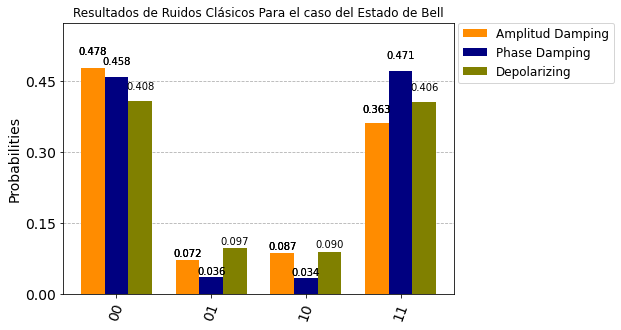

In [19]:
# Estado de Bell
tqc_Bell_noise_amp = transpile(qc_Bell, sim_noise_amp)
tqc_Bell_noise_phs = transpile(qc_Bell, sim_noise_phs)
tqc_Bell_noise_dprz = transpile(qc_Bell, sim_noise_dprz)

tqc_Bell_noise_amp_meas = tqc_Bell_noise_amp.copy()
tqc_Bell_noise_amp_meas.measure(mes_Bell,
                                [i for i in range(tqc_Bell_noise_amp_meas.cregs[0].size)])
result_Bell_noise_amp = sim_noise_amp.run(tqc_Bell_noise_amp_meas, shots=shots).result()

tqc_Bell_noise_phs_meas = tqc_Bell_noise_phs.copy()
tqc_Bell_noise_phs_meas.measure(mes_Bell,
                                [i for i in range(tqc_Bell_noise_phs_meas.cregs[0].size)])
result_Bell_noise_phs = sim_noise_phs.run(tqc_Bell_noise_phs_meas, shots=shots).result()

tqc_Bell_noise_dprz_meas = tqc_Bell_noise_dprz.copy()
tqc_Bell_noise_dprz_meas.measure(mes_Bell,
                                 [i for i in range(tqc_Bell_noise_dprz_meas.cregs[0].size)])
result_Bell_noise_dprz = sim_noise_dprz.run(tqc_Bell_noise_dprz_meas, shots=shots).result()

counts_Bell_noise_amp = result_Bell_noise_amp.get_counts(tqc_Bell_noise_amp_meas)
counts_Bell_noise_phs = result_Bell_noise_phs.get_counts(tqc_Bell_noise_phs_meas)
counts_Bell_noise_dprz = result_Bell_noise_dprz.get_counts(tqc_Bell_noise_dprz_meas)

plth(
    [counts_Bell_noise_amp,
     counts_Bell_noise_phs,
     counts_Bell_noise_dprz
    ],
    legend=['Amplitud Damping',
            'Phase Damping',
            'Depolarizing'
           ],
    title='Resultados de Ruidos Clásicos Para el caso del Estado de Bell',
    color=['darkorange',
           'navy',
           'olive'
           ],
    figsize=(7, 5)
)


In [44]:
print('Cuentas de la codificación para el estado de Bell con ruido tipo "Amplitud Damping": \n',counts_Bell_noise_amp)
for i in counts_Bell_noise_amp:
    print(i, ': ',counts_Bell_noise_amp[i], '/',counts_Bell_noise_amp[i]/shots)
print('Cuentas de la codificación para el estado de Bell con ruido tipo "Phase Damping": \n',counts_Bell_noise_phs)
for i in counts_Bell_noise_phs:
    print(i, ': ',counts_Bell_noise_phs[i], '/',counts_Bell_noise_phs[i]/shots)
print('Cuentas de la codificación para el estado de Bell con ruido tipo "Depolarizing": \n',counts_Bell_noise_dprz)
for i in counts_Bell_noise_dprz:
    print(i, ': ',counts_Bell_noise_dprz[i], '/',counts_Bell_noise_dprz[i]/shots)


Cuentas de la codificación para el estado de Bell con ruido tipo "Amplitud Damping": 
 {'00': 3919, '11': 2975, '01': 558, '10': 740}
00 :  3919 / 0.4783935546875
11 :  2975 / 0.3631591796875
01 :  558 / 0.068115234375
10 :  740 / 0.09033203125
Cuentas de la codificación para el estado de Bell con ruido tipo "Phase Damping": 
 {'00': 3781, '01': 321, '11': 3818, '10': 272}
00 :  3781 / 0.4615478515625
01 :  321 / 0.0391845703125
11 :  3818 / 0.466064453125
10 :  272 / 0.033203125
Cuentas de la codificación para el estado de Bell con ruido tipo "Depolarizing": 
 {'00': 3345, '10': 753, '11': 3347, '01': 747}
00 :  3345 / 0.4083251953125
10 :  753 / 0.0919189453125
11 :  3347 / 0.4085693359375
01 :  747 / 0.0911865234375


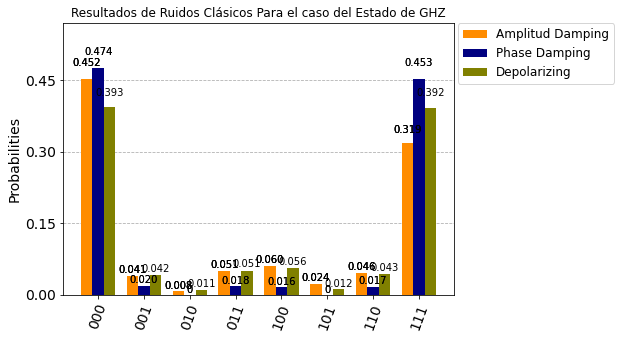

In [22]:
# Estado GHZ
tqc_GHZ_noise_amp = transpile(qc_GHZ, sim_noise_amp)
tqc_GHZ_noise_phs = transpile(qc_GHZ, sim_noise_phs)
tqc_GHZ_noise_dprz = transpile(qc_GHZ, sim_noise_dprz)

tqc_GHZ_noise_amp_meas = tqc_GHZ_noise_amp.copy()
tqc_GHZ_noise_amp_meas.measure(mes_GHZ,
                                [i for i in range(tqc_GHZ_noise_amp_meas.cregs[0].size)])
result_GHZ_noise_amp = sim_noise_amp.run(tqc_GHZ_noise_amp_meas, shots=shots).result()

tqc_GHZ_noise_phs_meas = tqc_GHZ_noise_phs.copy()
tqc_GHZ_noise_phs_meas.measure(mes_GHZ,
                                [i for i in range(tqc_GHZ_noise_phs_meas.cregs[0].size)])
result_GHZ_noise_phs = sim_noise_phs.run(tqc_GHZ_noise_phs_meas, shots=shots).result()

tqc_GHZ_noise_dprz_meas = tqc_GHZ_noise_dprz.copy()
tqc_GHZ_noise_dprz_meas.measure(mes_GHZ,
                                 [i for i in range(tqc_GHZ_noise_dprz_meas.cregs[0].size)])
result_GHZ_noise_dprz = sim_noise_dprz.run(tqc_GHZ_noise_dprz_meas, shots=shots).result()

counts_GHZ_noise_amp = result_GHZ_noise_amp.get_counts(tqc_GHZ_noise_amp_meas)
counts_GHZ_noise_phs = result_GHZ_noise_phs.get_counts(tqc_GHZ_noise_phs_meas)
counts_GHZ_noise_dprz = result_GHZ_noise_dprz.get_counts(tqc_GHZ_noise_dprz_meas)

plth(
    [counts_GHZ_noise_amp,
     counts_GHZ_noise_phs,
     counts_GHZ_noise_dprz
    ],
    legend=['Amplitud Damping',
            'Phase Damping',
            'Depolarizing'
           ],
    title='Resultados de Ruidos Clásicos Para el caso del Estado de GHZ',
    color=['darkorange',
           'navy',
           'olive'
          ],
    figsize=(7, 5)
)



In [45]:
print('Cuentas de la codificación para el estado GHZ con ruido tipo "Amplitud Damping": \n',counts_GHZ_noise_amp)
for i in counts_GHZ_noise_amp:
    print(i, ': ',counts_GHZ_noise_amp[i], '/',counts_GHZ_noise_amp[i]/shots)
print('Cuentas de la codificación para el estado GHZ con ruido tipo "Phase Damping": \n',counts_GHZ_noise_phs)
for i in counts_GHZ_noise_phs:
    print(i, ': ',counts_GHZ_noise_phs[i], '/',counts_GHZ_noise_phs[i]/shots)
print('Cuentas de la codificación para el estado GHZ con ruido tipo "Depolarizing": \n',counts_GHZ_noise_dprz)
for i in counts_GHZ_noise_dprz:
    print(i, ': ',counts_GHZ_noise_dprz[i], '/',counts_GHZ_noise_dprz[i]/shots)


Cuentas de la codificación para el estado GHZ con ruido tipo "Amplitud Damping": 
 {'000': 3719, '001': 302, '111': 2658, '101': 174, '110': 412, '100': 462, '010': 59, '011': 406}
000 :  3719 / 0.4539794921875
001 :  302 / 0.036865234375
111 :  2658 / 0.324462890625
101 :  174 / 0.021240234375
110 :  412 / 0.05029296875
100 :  462 / 0.056396484375
010 :  59 / 0.0072021484375
011 :  406 / 0.049560546875
Cuentas de la codificación para el estado GHZ con ruido tipo "Phase Damping": 
 {'000': 3776, '111': 3820, '100': 154, '001': 152, '011': 161, '110': 119, '101': 4, '010': 6}
000 :  3776 / 0.4609375
111 :  3820 / 0.46630859375
100 :  154 / 0.018798828125
001 :  152 / 0.0185546875
011 :  161 / 0.0196533203125
110 :  119 / 0.0145263671875
101 :  4 / 0.00048828125
010 :  6 / 0.000732421875
Cuentas de la codificación para el estado GHZ con ruido tipo "Depolarizing": 
 {'111': 3222, '011': 455, '110': 346, '000': 3178, '100': 438, '101': 87, '001': 380, '010': 86}
111 :  3222 / 0.39331054687

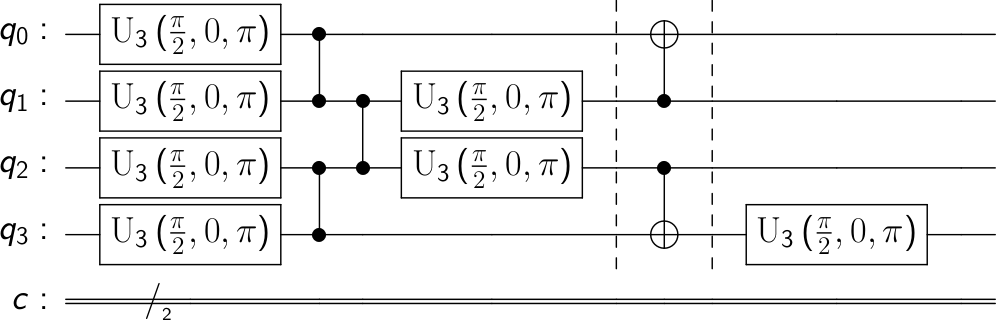

6

In [23]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]
display(tqc_Bell_noise_amp.draw('latex'),
        tqc_Bell_noise_amp.depth()
       )


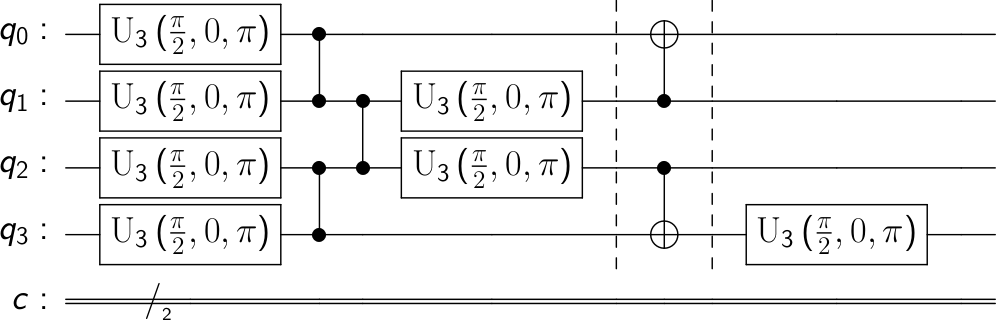

In [49]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]
tqc_Bell_noise_phs.draw('latex')

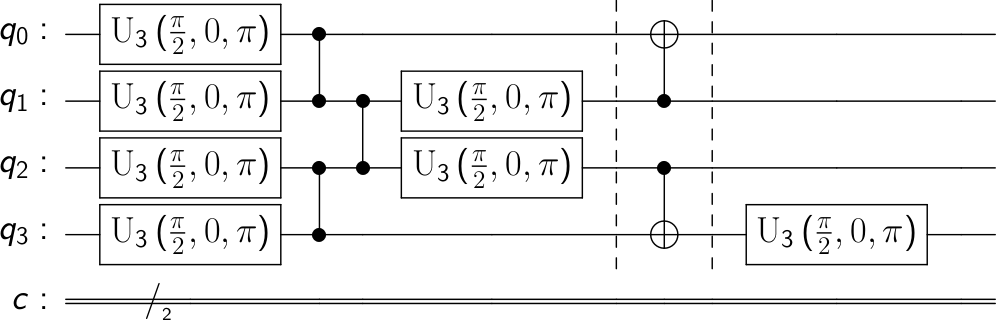

In [50]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]
tqc_Bell_noise_dprz.draw('latex')

In [26]:
t = time.time()

P_amp = tomo(qc=codBell(False),
             backend=sim_noise_amp,
             qubits=[0, 1, 2, 3],
            ) 

F_amp = qi.state_fidelity(P_amp[0], qc_Bell_sv)
F_amp_mit = qi.state_fidelity(P_amp[2], qc_Bell_sv)
print('Fidelidad en el Modelo de Ruido "Amplitud Damping" para el estado de Bell (s/ corrección): F = {:.5f}'.format(F_amp))
print('                                                                          (c/ corrección): F = {:.5f}'.format(F_amp_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_amp[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_amp[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de Ruido "Amplitud Damping" para el estado de Bell (s/ corrección): F = 0.68420
                                                                          (c/ corrección): F = 0.72843


Tiempo de ejecución [minutos] (s/ corrección): t = 0.02194
                              (c/ corrección): t = 0.02773


Tiempo transcurrido [segundos] : t = 3.99730


In [27]:
t = time.time()

P_phs = tomo(qc=codBell(False),
             backend=sim_noise_phs,
             qubits=[0, 1, 2, 3],
            ) 

F_phs = qi.state_fidelity(P_phs[0], qc_Bell_sv)
F_phs_mit = qi.state_fidelity(P_phs[2], qc_Bell_sv)
print('Fidelidad en el Modelo de Ruido "Phase Damping" para el estado de Bell (s/ corrección): F = {:.5f}'.format(F_phs))
print('                                                                       (c/ corrección): F = {:.5f}'.format(F_phs_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_phs[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_phs[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de Ruido "Phase Damping" para el estado de Bell (s/ corrección): F = 0.81009
                                                                       (c/ corrección): F = 0.81009


Tiempo de ejecución [minutos] (s/ corrección): t = 0.02309
                              (c/ corrección): t = 0.04631


Tiempo transcurrido [segundos] : t = 4.98167


In [28]:
t = time.time()

P_dprz = tomo(qc=codBell(False),
             backend=sim_noise_dprz,
             qubits=[0, 1, 2, 3],
            ) 

F_dprz = qi.state_fidelity(P_dprz[0], qc_Bell_sv)
F_dprz_mit = qi.state_fidelity(P_dprz[2], qc_Bell_sv)
print('Fidelidad en el Modelo de Ruido "Depolarizing" para el estado de Bell (s/ corrección): F = {:.5f}'.format(F_dprz))
print('                                                                      (c/ corrección): F = {:.5f}'.format(F_dprz))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_dprz[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_dprz[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de Ruido "Depolarizing" para el estado de Bell (s/ corrección): F = 0.59707
                                                                      (c/ corrección): F = 0.59707


Tiempo de ejecución [minutos] (s/ corrección): t = 0.02412
                              (c/ corrección): t = 0.04629


Tiempo transcurrido [segundos] : t = 5.18612


In [51]:
f_Bell_amp = fid(qc_Bell, tqc_Bell_noise_amp, noisy_amp, shots)
f_Bell_phs = fid(qc_Bell, tqc_Bell_noise_phs, noisy_phs, shots)
f_Bell_dprz = fid(qc_Bell, tqc_Bell_noise_dprz, noisy_dprz, shots)

print(f_Bell_amp)
print(f_Bell_phs)
print(f_Bell_dprz)

0.711432984522943
0.8051757812500001
0.6582031250000001


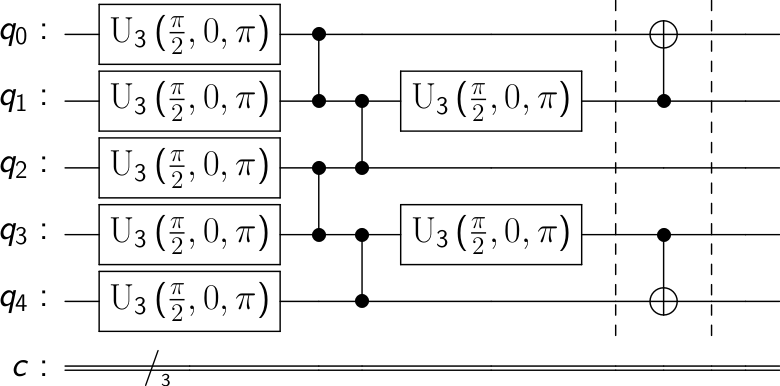

5

In [24]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]
display(tqc_GHZ_noise_amp.draw('latex'),
        tqc_GHZ_noise_amp.depth()
       )


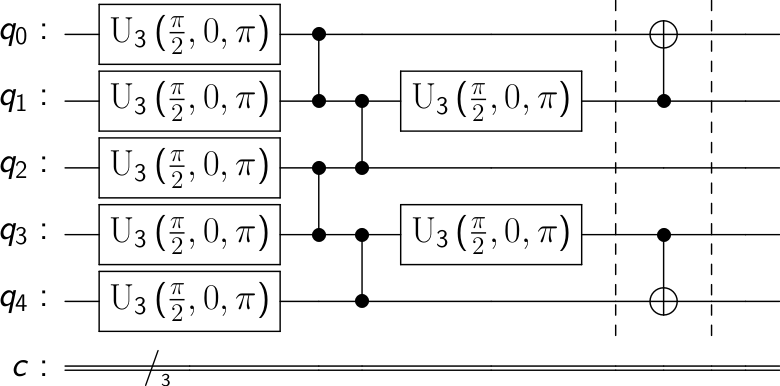

In [53]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]
tqc_GHZ_noise_phs.draw('latex')

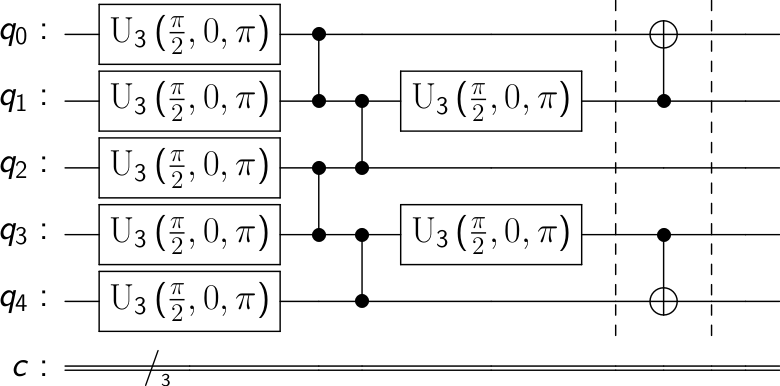

In [54]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]
tqc_GHZ_noise_dprz.draw('latex')

In [22]:
t = time.time()

P_amp = tomo(qc=codGHZ(False),
             backend=sim_noise_amp,
             qubits=[0, 1, 2, 3, 4],
            ) 

F_amp = qi.state_fidelity(P_amp[0], qc_GHZ_sv)
F_amp_mit = qi.state_fidelity(P_amp[2], qc_GHZ_sv)
print('Fidelidad en el Modelo de Ruido "Amplitud Damping" para el estado GHZ (s/ corrección): F = {:.5f}'.format(F_amp))
print('                                                                      (c/ corrección): F = {:.5f}'.format(F_amp_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_amp[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_amp[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


C:\ProgramData\Anaconda3\envs\MyEnv\lib\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:468: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  prep += circuit
C:\ProgramData\Anaconda3\envs\MyEnv\lib\site-packages\qiskit\circuit\quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)
C:\ProgramData\Anaconda3\envs\MyEnv\lib\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:478: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circ = prep + meas
C:\Prog

Fidelidad en el Modelo de Ruido "Amplitud Damping" para el estado GHZ (s/ corrección): F = 0.64103
                                                                      (c/ corrección): F = 0.70990


Tiempo de ejecución [minutos] (s/ corrección): t = 0.07974
                              (c/ corrección): t = 0.08966


Tiempo transcurrido [segundos] : t = 26.38938


In [23]:
t = time.time()

P_phs = tomo(qc=codGHZ(False),
             backend=sim_noise_phs,
             qubits=[0, 1, 2, 3, 4],
            ) 

F_phs = qi.state_fidelity(P_phs[0], qc_GHZ_sv)
F_phs_mit = qi.state_fidelity(P_phs[2], qc_GHZ_sv)
print('Fidelidad en el Modelo de Ruido "Phase Damping" para el estado GHZ (s/ corrección): F = {:.5f}'.format(F_phs))
print('                                                                   (c/ corrección): F = {:.5f}'.format(F_phs_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_phs[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_phs[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de Ruido "Phase Damping" para el estado GHZ (s/ corrección): F = 0.78843
                                                                   (c/ corrección): F = 0.78843


Tiempo de ejecución [minutos] (s/ corrección): t = 0.14152
                              (c/ corrección): t = 0.20450


Tiempo transcurrido [segundos] : t = 39.50429


In [24]:
t = time.time()

P_dprz = tomo(qc=codGHZ(False),
             backend=sim_noise_dprz,
             qubits=[0, 1, 2, 3, 4],
            ) 

F_dprz = qi.state_fidelity(P_dprz[0], qc_GHZ_sv)
F_dprz_mit = qi.state_fidelity(P_dprz[2], qc_GHZ_sv)
print('Fidelidad en el Modelo de Ruido "Depolarizing" para el estado GHZ (s/ corrección): F = {:.5f}'.format(F_dprz))
print('                                                                  (c/ corrección): F = {:.5f}'.format(F_dprz))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_dprz[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_dprz[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de Ruido "Depolarizing" para el estado GHZ (s/ corrección): F = 0.56421
                                                                  (c/ corrección): F = 0.56421


Tiempo de ejecución [minutos] (s/ corrección): t = 0.07977
                              (c/ corrección): t = 0.13516


Tiempo transcurrido [segundos] : t = 23.18171


In [55]:
f_GHZ_amp = fid(qc_GHZ, tqc_GHZ_noise_amp, noisy_amp, shots)
f_GHZ_phs = fid(qc_GHZ, tqc_GHZ_noise_phs, noisy_phs, shots)
f_GHZ_dprz = fid(qc_GHZ, tqc_GHZ_noise_dprz, noisy_dprz, shots)

print(f_GHZ_amp)
print(f_GHZ_phs)
print(f_GHZ_dprz)

0.6819984121827123
0.7849121093750001
0.6340332031250001


In [56]:
f_Bell_amp_sweep = []
f_Bell_phs_sweep = []
f_Bell_dprz_sweep = []
p_Bell_i = []
n = 1600

for i in range(0, n):
    p_Bell_i.append(i/n)
    print(i)
    noisy_amp_sweep = amp_noise(p=i/n)
    noisy_phs_sweep = phs_noise(p=i/n)
    noisy_dprz_sweep = dprz_noise(p=i/n)
    
    tqc_Bell_noise_amp_sweep = transpile(qc_Bell, AerSimulator(noise_model=noisy_amp))
    tqc_Bell_noise_phs_sweep = transpile(qc_Bell, AerSimulator(noise_model=noisy_phs))
    tqc_Bell_noise_dprz_sweep = transpile(qc_Bell, AerSimulator(noise_model=noisy_dprz))

    f_Bell_amp_sweep.append(fid(qc_Bell, tqc_Bell_noise_amp_sweep, noisy_amp_sweep, shots))
    f_Bell_phs_sweep.append(fid(qc_Bell, tqc_Bell_noise_phs_sweep, noisy_phs_sweep, shots))
    f_Bell_dprz_sweep.append(fid(qc_Bell, tqc_Bell_noise_dprz_sweep, noisy_dprz_sweep, shots))
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

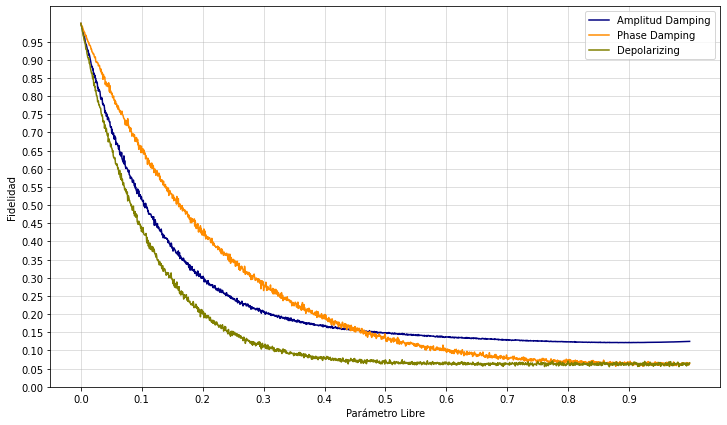

In [57]:
mpl.rcParams["figure.figsize"] = (12,7)
plt.plot(p_Bell_i, f_Bell_amp_sweep, color='navy', label='Amplitud Damping')
plt.plot(p_Bell_i, f_Bell_phs_sweep, color='darkorange', label='Phase Damping')
plt.plot(p_Bell_i, f_Bell_dprz_sweep, color='olive', label='Depolarizing')
plt.xlabel("Parámetro Libre")
plt.ylabel("Fidelidad")
plt.legend(loc='upper right');
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.05))
plt.grid(alpha=0.2)
plt.grid(alpha=0.5)
plt.show()

In [58]:
f_GHZ_amp_sweep = []
f_GHZ_phs_sweep = []
f_GHZ_dprz_sweep = []
p_GHZ_i = []
n = 1600

for i in range(0, n):
    p_GHZ_i.append(i/n)
    print(i)
    noisy_amp_sweep = amp_noise(p=i/n)
    noisy_phs_sweep = phs_noise(p=i/n)
    noisy_dprz_sweep = dprz_noise(p=i/n)
    
    tqc_GHZ_noise_amp_sweep = transpile(qc_GHZ, AerSimulator(noise_model=noisy_amp))
    tqc_GHZ_noise_phs_sweep = transpile(qc_GHZ, AerSimulator(noise_model=noisy_phs))
    tqc_GHZ_noise_dprz_sweep = transpile(qc_GHZ, AerSimulator(noise_model=noisy_dprz))

    f_GHZ_amp_sweep.append(fid(qc_GHZ, tqc_GHZ_noise_amp_sweep, noisy_amp_sweep, shots))
    f_GHZ_phs_sweep.append(fid(qc_GHZ, tqc_GHZ_noise_phs_sweep, noisy_phs_sweep, shots))
    f_GHZ_dprz_sweep.append(fid(qc_GHZ, tqc_GHZ_noise_dprz_sweep, noisy_dprz_sweep, shots))
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

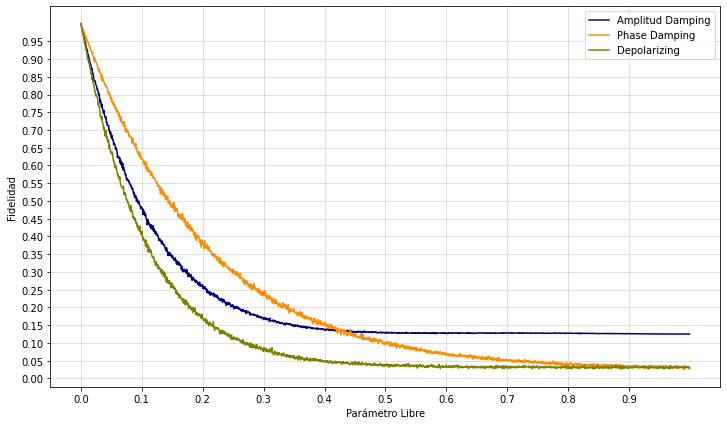

In [59]:
mpl.rcParams["figure.figsize"] = (12,7)
plt.plot(p_GHZ_i, f_GHZ_amp_sweep, color='navy', label='Amplitud Damping')
plt.plot(p_GHZ_i, f_GHZ_phs_sweep, color='darkorange', label='Phase Damping')
plt.plot(p_GHZ_i, f_GHZ_dprz_sweep, color='olive', label='Depolarizing')
plt.xlabel("Parámetro Libre")
plt.ylabel("Fidelidad")
plt.legend(loc='upper right');
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.05))
plt.grid(alpha=0.2)
plt.grid(alpha=0.5)
plt.show()